In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from matplotlib.ticker import MultipleLocator
from scipy.stats import t as t_dist


# Functions

In [2]:
# Funzione gaussiana
def gaussian_offset(x, A, mu, sigma, m, q):
    return A*(1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) + m *x +q


In [3]:
def chi_square_func(exp, theo, err, popt):
    dof = len(exp)-len(popt)
    chi = np.sum(((exp-theo)/ err)**2 )
    chi_red = chi/dof
    return chi, chi_red

In [4]:
def fit_func(spectrum, center, dx=15, kev=False, energies=None, plot = True, ax=None):
    center = int(round(center))  # <-- Add this
    if kev:
        
        mask = (energies > center - dx) & (energies < center + dx)
        x_data = energies[mask]
        y_data = spectrum[mask]
    else:
        window = dx       
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]


    y_data = [y + 25000 if y == 0 else y for y in y_data]

    

    dof = len(x_data) -5

    err_counts = [np.sqrt(c) if c > 0 else 1 for c in y_data]
    for i in range(len(err_counts)):
        if err_counts[i]==0:
            print(i)

    initial_guess = [max(y_data), center, 1, 0, 10]
    bounds = (
        [0, center - 5, 0.0001, -10000, 1],
        [100000* max(y_data), center + 5, 10, 1000000, max(y_data)]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_data, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()

    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)

    if plot:
        
        counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_data,
                                      histtype='step', color = 'black', label='Hist data')
        '''ax.errorbar(x_data, y_data, yerr = err_counts, 
                    markersize = 5,
                    capsize=5,
                    alpha = 0.86,
                    fmt = 'o',
                    color='dimgray',
                   label = 'Data')'''
        
        db = bin_edges[1]-bin_edges[0]
        
        xfit = np.linspace(x_data[0], x_data[-1]+1, 500)
        yfit = gaussian_offset(xfit, *popt)
        ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
        ax.set_xlim(min(x_data), max(x_data))
        if kev:
            dx = 2
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f} keV')
            ax.set_xlabel('E [keV]', size = 12)
            ax.set_title(f'Gaussian fit @ {center} keV', size = 15)
            ax.set_ylabel(f'Counts / {db:.1f} keV', size = 12)
        else:

            dx = 10
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            
            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f}')
            ax.set_xlabel('Channel', size = 12)
            ax.set_title(f'Gaussian fit @ {center} chn', size = 15)
            ax.set_ylabel(f'Counts / {db:.0f} chn', size = 12)
        ax.grid(alpha=0.25)
        ax.legend(loc = 'upper left')

    chi, chi_red = chi_square_func(x_data, gaussian_offset(x_data, *popt), err_counts, popt)
     
 #   print(r"$\chi^2$", chi)
 #   print(r'$\chi^2$/ dof', chi_red)
    

    return popt, err, dof




In [5]:
def k_calibration(E_chn, a, b):
    return E_chn * a + b

In [6]:
def t_test_theoretical(x_exp, sigma, x_theo, dof):
    t_stat = (x_exp - x_theo) / sigma
    print(f't = {t_stat:.2f}')
    
    # p-value a due code
    p_value = 2 * t_dist.sf(abs(t_stat), df=dof)

    if p_value < 0.05:
        print('❌ p < 0.05 ')
    else:
        print('✅ p > 0.05 ')
    print(f'p-value = {p_value:.4f}')
    return t_stat, p_value

In [7]:
def fhwm_func(E, a, b):
    return np.sqrt( (a / np.sqrt(E))**2 + b**2)


In [8]:
import numpy as np

def fwhm_percentuale(sigma, delta_sigma, E, delta_E):

    sigma = np.array(sigma)
    delta_sigma = np.array(delta_sigma)
    E = np.array(E)
    delta_E = np.array(delta_E)

    # Calcolo FWHM percentuale: (2.355 * sigma) / E 
    fwhm_perc = (2.355 * sigma / E) 

    # Propagazione dell'errore relativa
    rel_err_sigma = delta_sigma / sigma
    rel_err_E = delta_E / E
    delta_fwhm_perc = fwhm_perc * np.sqrt(rel_err_sigma**2 + rel_err_E**2)

    return fwhm_perc, delta_fwhm_perc


In [9]:
def fit_func_sottratto(spectrum, background, center, dx=50, kev=False, energies=None, ax=None):
    if kev:
        if energies is None:
            raise ValueError("Devi fornire 'energies' se kev=True")
        mask = (energies > center - dx) & (energies < center + dx + 1)
        x_data = energies[mask]
        y_data = spectrum[mask]
        y_bkg = background[mask]
    else:
        window = dx
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]
        y_bkg = background[center - window:center + window + 1]

    y_sub = y_data - y_bkg
    if center == 1661.28:
        y_sub[y_sub <= 0] = 300
    else:
        y_sub[y_sub < 0] = 0
    
    err_counts = [np.sqrt(d + b) if (d + b) > 0 else 1 for d, b in zip(y_data, y_bkg)]

    valid_mask = y_sub > 0
    x_data = x_data[valid_mask]
    y_sub = y_sub[valid_mask]
    y_sub = [y + 250000 if y == 0 else y for y in y_sub]
    err_counts = np.array(err_counts)[valid_mask]
    dof = len(x_data) -5

    initial_guess = [max(y_sub), center, 5, 0, 1100]
    bounds = (
        [0, center - 1, 0.01, -1000, 0],
        [1000 * max(y_sub), center + 1, 25, 1000, np.inf]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_sub, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()
    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)
    counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_sub,
                                   histtype='step', color='black', label='Hist data')
    '''
    ax.errorbar(x_data, y_sub, yerr=err_counts,
                markersize=5,
                capsize=5,
                alpha=0.86,
                fmt='o',
                color='dimgray',
                label='Data')
    '''
    xfit = np.linspace(min(x_data), max(x_data), 500)
    yfit = gaussian_offset(xfit, *popt)
    ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
    ax.set_xlim(min(x_data), max(x_data))

    ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--',
              label=f'Peak: {popt[1]:.2f} {"keV" if kev else ""}')

    # Label e titolo coerenti con fit_func
    if kev:
        ax.set_xlabel('E [keV]', size=12)
        ax.set_title(f'Gaussian fit @ {center} keV', size=15)
    else:
        ax.set_xlabel('Channel', size=12)
        ax.set_title(f'Gaussian fit @ {center} chn', size=15)

    ax.set_ylabel('Counts', size=12)
    ax.grid(alpha=0.25)
    ax.legend()

    return popt, err, dof


In [10]:
def get_eff_value(energia, x_eff, eff_value):
    idx = np.abs(x_eff - energia).argmin()
    return eff_value[idx]

# Background

In [11]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b
spectrum_bkg[spectrum_bkg < 0] = 0 


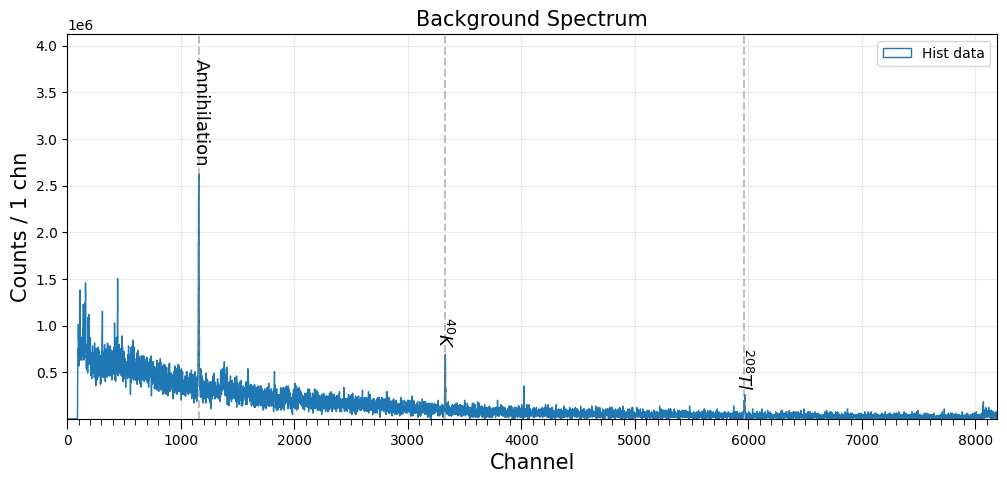

In [12]:
plt.figure(figsize=(12, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero


chn = np.arange(len(spectrum_bkg))  # canali da 0 a N-1
#plt.bar(chn, spectrum_bkg, width=1.0, label='Spectrum')
#plt.plot(spectrum_bkg, lw = 0.5, label='Spectrum')
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_bkg,
                                      histtype='step', label='Hist data')

db = bin_edges[1]-bin_edges[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum', size = 15)
plt.text(1100,  2.75e6, "Annihilation", rotation=270,  size = 13)
plt.text(3229 , 0.8e6, r'$^{40}K$', rotation=270,  size = 13)
plt.text(5865 , 0.35e6, r'$^{208}Tl$', rotation=270,  size = 13)
plt.vlines(1157,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(3329,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(5965,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.xlim(0, len(spectrum_bkg))
plt.ylim(1,max(spectrum_bkg)+ 1500000)
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/ HPGe background", dpi=300, bbox_inches='tight')

In [13]:
65/4

16.25

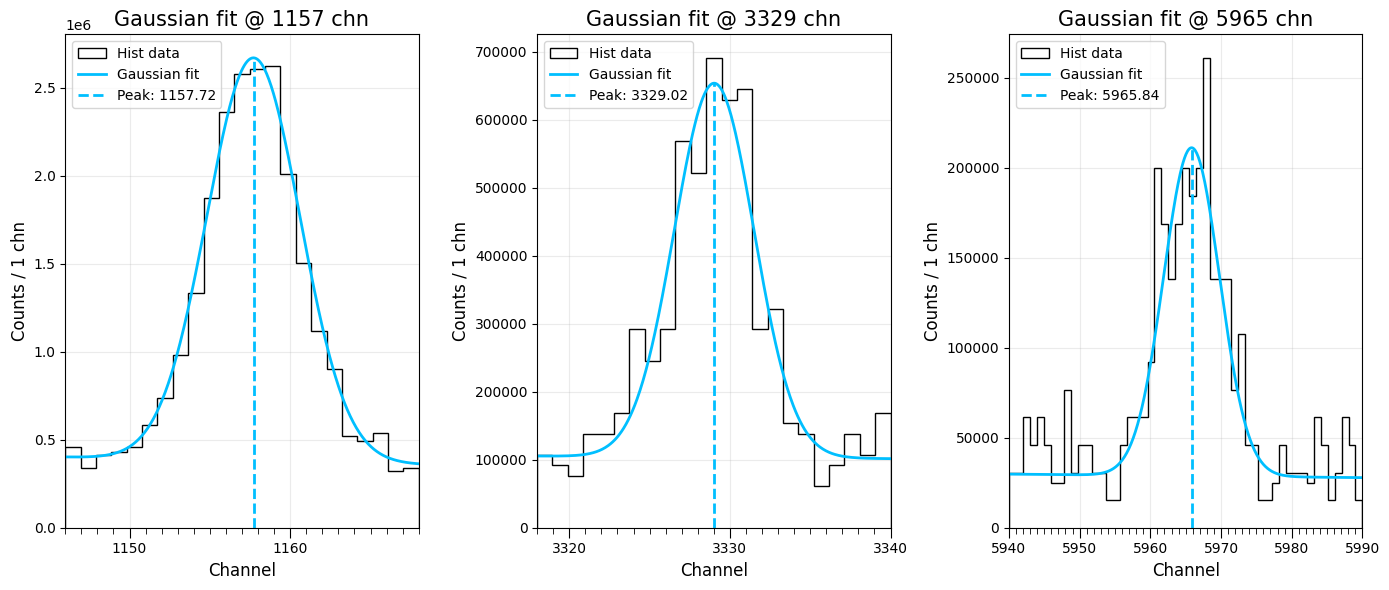

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # 1 riga, 3 colonne

E_chn = [1157, 3329, 5965] 
popt_chn = []
popt_chn_err = []

for i, e in enumerate(E_chn):
    dx = 25 if e == E_chn[-1] else 11
    popt, err, _ = fit_func(spectrum_bkg, e, dx=dx, ax=axes[i])
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("new image/ chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [15]:
popt_chn

array([[ 1.66677483e+07,  1.15771829e+03,  2.90176865e+00,
        -1.93928868e+03,  2.62491840e+06],
       [ 3.42241508e+06,  3.32902158e+03,  2.48294991e+00,
        -1.76375222e+02,  6.90768000e+05],
       [ 1.80930157e+06,  5.96584197e+03,  3.96122318e+00,
        -3.89105172e+01,  2.60956800e+05]])

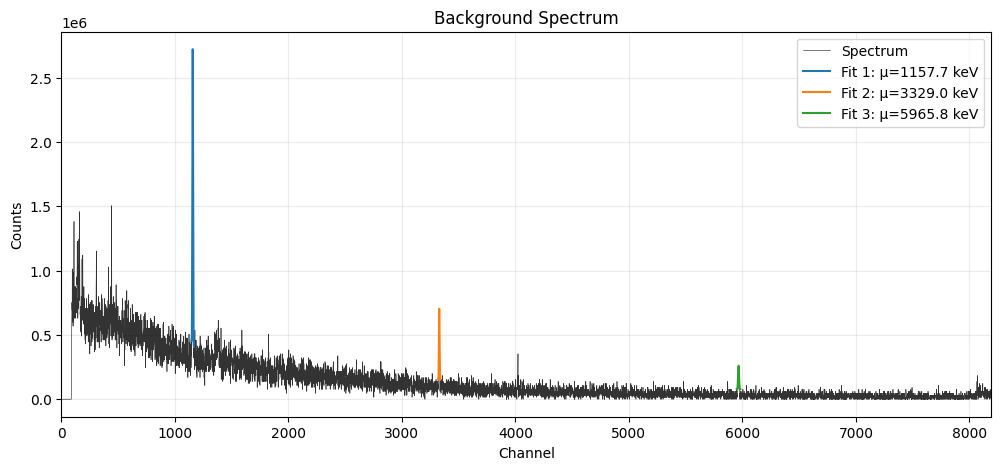

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(spectrum_bkg, color = 'black', lw = 0.46, alpha = 0.8, label='Spectrum')
for i, popt in enumerate(popt_chn):
    A, mu, sigma, m, q = popt
    x_fit = np.linspace(mu - 4*sigma, mu + 4*sigma, 300)
    y_fit = gaussian_offset(x_fit, A, mu, sigma,m, q+50000)
    plt.plot(x_fit, y_fit,  label=f'Fit {i+1}: μ={mu:.1f} keV')


plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, len(spectrum_bkg))
#plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

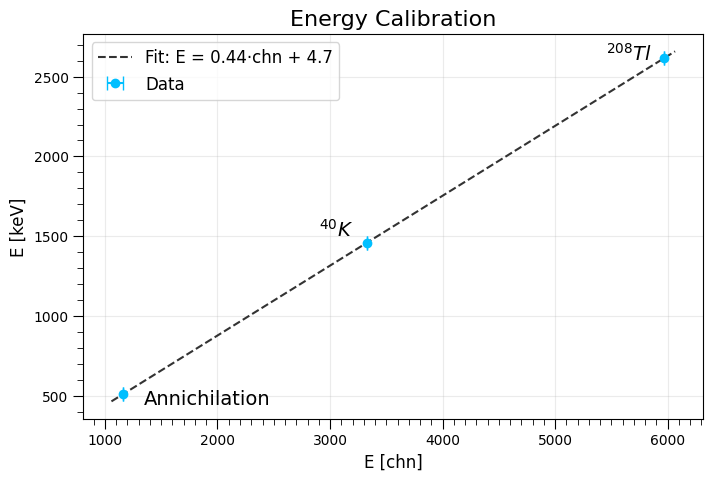

In [17]:
E_kev = [511, 1460.830, 2614] #kev

plt.figure(figsize=(8, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero



plt.errorbar( popt_chn[:,1],E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn[:,1], E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_bkg = popt[0]
b_bkg = popt[1]

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
plt.text(1350 , 450, "Annichilation", rotation=0,  size = 14)
plt.text(2900 , 1500, r'$^{40}K$', rotation=0,  size = 14)
plt.text(5450 , 2600, r'$^{208}Tl$', rotation=0,  size = 14)
plt.legend(fontsize = 12)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/ E_cal_bkg", dpi=300, bbox_inches='tight')

In [18]:
##### print(a_bkg , '+/-', perr[0])
print(b_bkg , '+/-', perr[1])

4.682977688622721 +/- 0.12933836497593104


In [19]:
channels_bkg = np.arange(len(spectrum_bkg))         # x originale
energies_bkg = a_bkg * channels_bkg + b_bkg  
energies_bkg_err = np.sqrt(np.diag(pcov))[0]*channels_bkg + np.sqrt(np.diag(pcov))[1]

In [20]:
b_bkg

np.float64(4.682977688622721)

In [21]:
energies_bkg[1]-energies_bkg[0]

np.float64(0.43738294846886117)

In [22]:
mask = (energies_bkg > 60) & (energies_bkg < 3000)
spectr_3Mev = spectrum_bkg[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_real_b), 'cps')

1157773219.1992822
attività grezza 15084.599999990647 cps


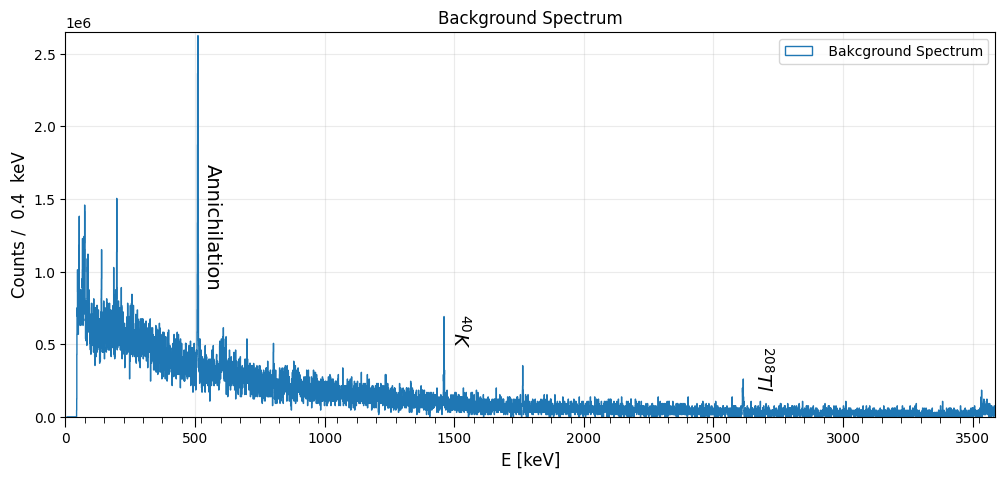

In [23]:
plt.figure(figsize=(12,5))

dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




bins = np.linspace(min(energies_bkg), max(energies_bkg), len(energies_bkg))
counts, bin_edge, _ = plt.hist(energies_bkg, bins = bins, weights = spectrum_bkg, lw = 0.5,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]- bin_edge[0]
plt.xlabel('E [keV]', size = 12)
plt.ylabel(f'Counts / {db: .1f}  keV', size = 12)
plt.title('Background Spectrum')
plt.xlim(0, max(energies_bkg))
plt.ylim(0, max(spectrum_bkg)+25000)
plt.text(530 , 0.9e6, "Annichilation", rotation=270,  size = 14)
plt.text(1480 , 0.5e6, r'$^{40}K$', rotation=270,  size = 14)
plt.text(2650 , 0.2e6, r'$^{208}Tl$', rotation=270,  size = 14)
plt.savefig("HPGe images/ spectrum_bkg_kev", dpi=300, bbox_inches='tight')
plt.legend(loc = 'upper right')
plt.grid(alpha = 0.25)
plt.savefig("new image/bkg_spectrum_kev", dpi=300, bbox_inches='tight')

In [24]:
for i in range(0,len(energies_bkg)):
    if spectrum_bkg[i] != 0:
        print(f' Energy threshold at {energies_bkg[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.61 keV


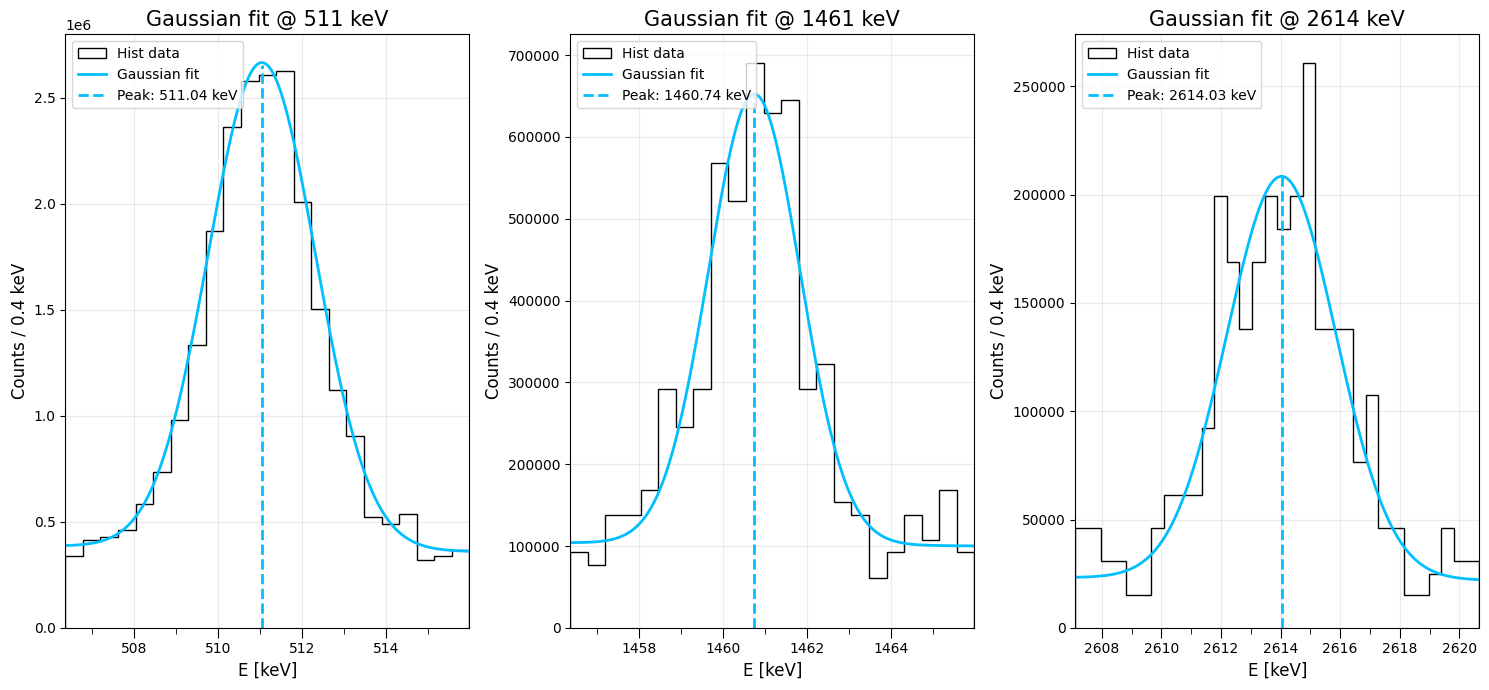

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 riga, 3 colonne
E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
for i, e in enumerate(E_kev):
    if e == 2614:
        dx = 7
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_bkg, e, dx = dx, kev = True, energies = energies_bkg, ax=axes[i])
    popt_kev.append(popt)
    popt_kev_err.append(err)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("new image/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [26]:
dofs 

[18, 18, 27]

In [27]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = dofs[i])
    

t = 1.35
✅ p > 0.05 
p-value = 0.1944
t = -0.90
✅ p > 0.05 
p-value = 0.3794
t = 0.21
✅ p > 0.05 
p-value = 0.8364


incertezza grandi solo 3 punti del fit
paramters: [1.13071637e-01 3.63513297e-24]
Errori: [4.68435629e-02 5.71544255e+02]


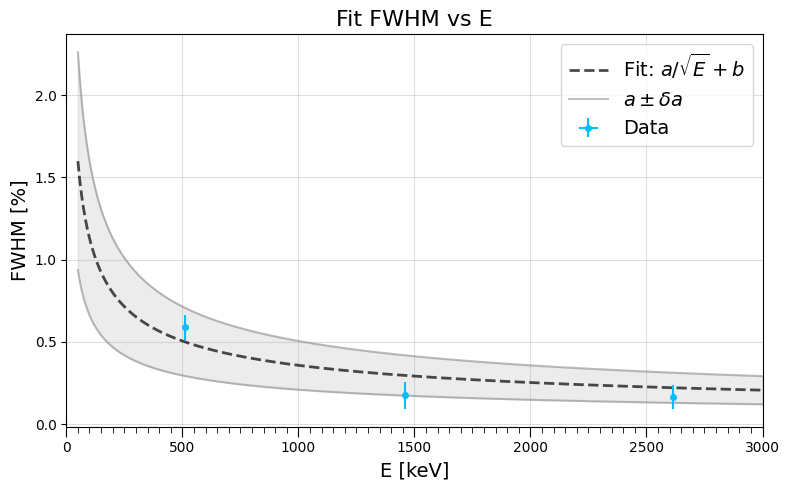

In [28]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_back_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))

dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero





plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, popt[0] + perr_back_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - perr_back_res[0], popt[1]) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*5*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

a_res_bkg = popt[0]
b_res_bkg  = popt[1]

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("new image/FWHM_bkg", dpi=300, bbox_inches='tight')
plt.show()

# Background open

In [29]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)


# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto
D_b = 1-(t_live_open/t_real_open)

spectrum_open = spectrum_open/D_b
spectrum_open[spectrum_open < 0] = 0 


In [30]:
1-t_live_open/t_real_open

0.0007877521663184339

In [31]:
E_chn_plot = [535, 665, 763 ,795,  1324, 1383, 1503,  2074 , 2206 ,2552, 2822, 3141, 3442, 3196,
        3331,  3947, 4026,  5032 ,5971]

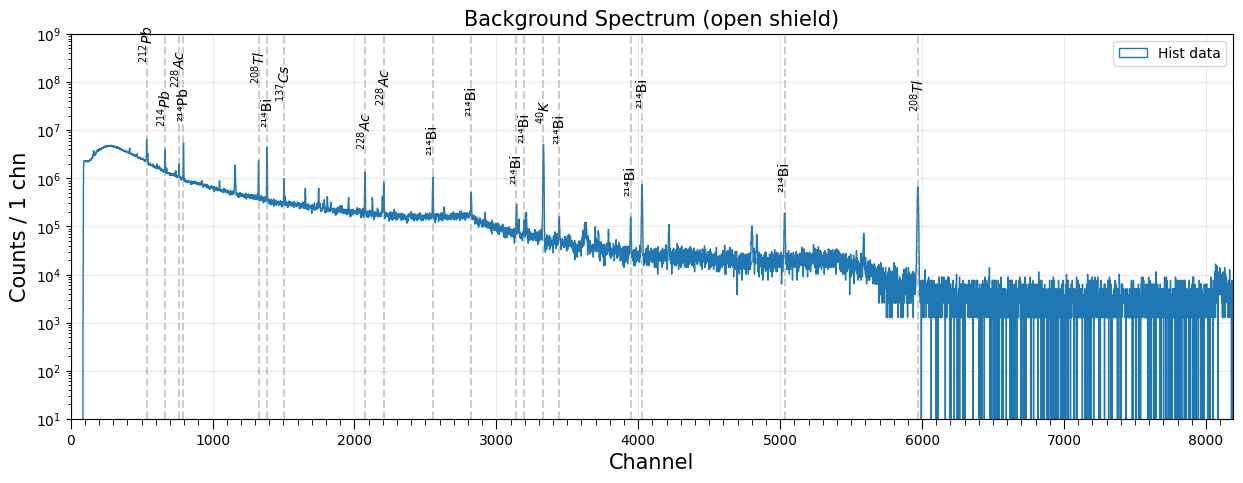

In [32]:
plt.figure(figsize=(15, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




chn = np.arange(len(spectrum_open))  # canali da 0 a N-1
#plt.bar(chn, spectrum_bkg, width=1.0, label='Spectrum')
#plt.plot(spectrum_bkg, lw = 0.5, label='Spectrum')

isotopes= ['$^{212}Pb$','$^{214}Pb$',
           '$^{228}Ac $',  '²¹⁴Pb', 
               '$^{208}Tl $','²¹⁴Bi',
           '$^{137}Cs $','$^{228}Ac $','$^{228}Ac $',
               '²¹⁴Bi','²¹⁴Bi',
               '²¹⁴Bi','²¹⁴Bi',
                '$^{40}K $',
                '²¹⁴Bi','²¹⁴Bi',
              '²¹⁴Bi', '²¹⁴Bi','$^{208}Tl $']



bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_open,
                                      histtype='step', label='Hist data')

db = bin_edges[1]-bin_edges[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum (open shield)', size = 15)
plt.xlim(0, len(spectrum_open))
plt.ylim(1e1,max(spectrum_open)+ 1e9)
E_chn = np.sort(E_chn_plot)
for i, (chn, iso) in enumerate(zip(E_chn, isotopes)):
    if chn < len(spectrum_open):
        # Alterna l'altezza del testo tra 1x e 3x
        factor = 40 if i % 2 == 0 else 3
        plt.text(chn, spectrum_open[chn]*factor, f"{iso}",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
'''
plt.text(2132, 1e7, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=2132, color='gray', linestyle='--', alpha=0.4)

plt.text(2632, 1e7, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=2632, color='gray', linestyle='--', alpha=0.4)
'''
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/spettro_chn_op", dpi=300, bbox_inches='tight')

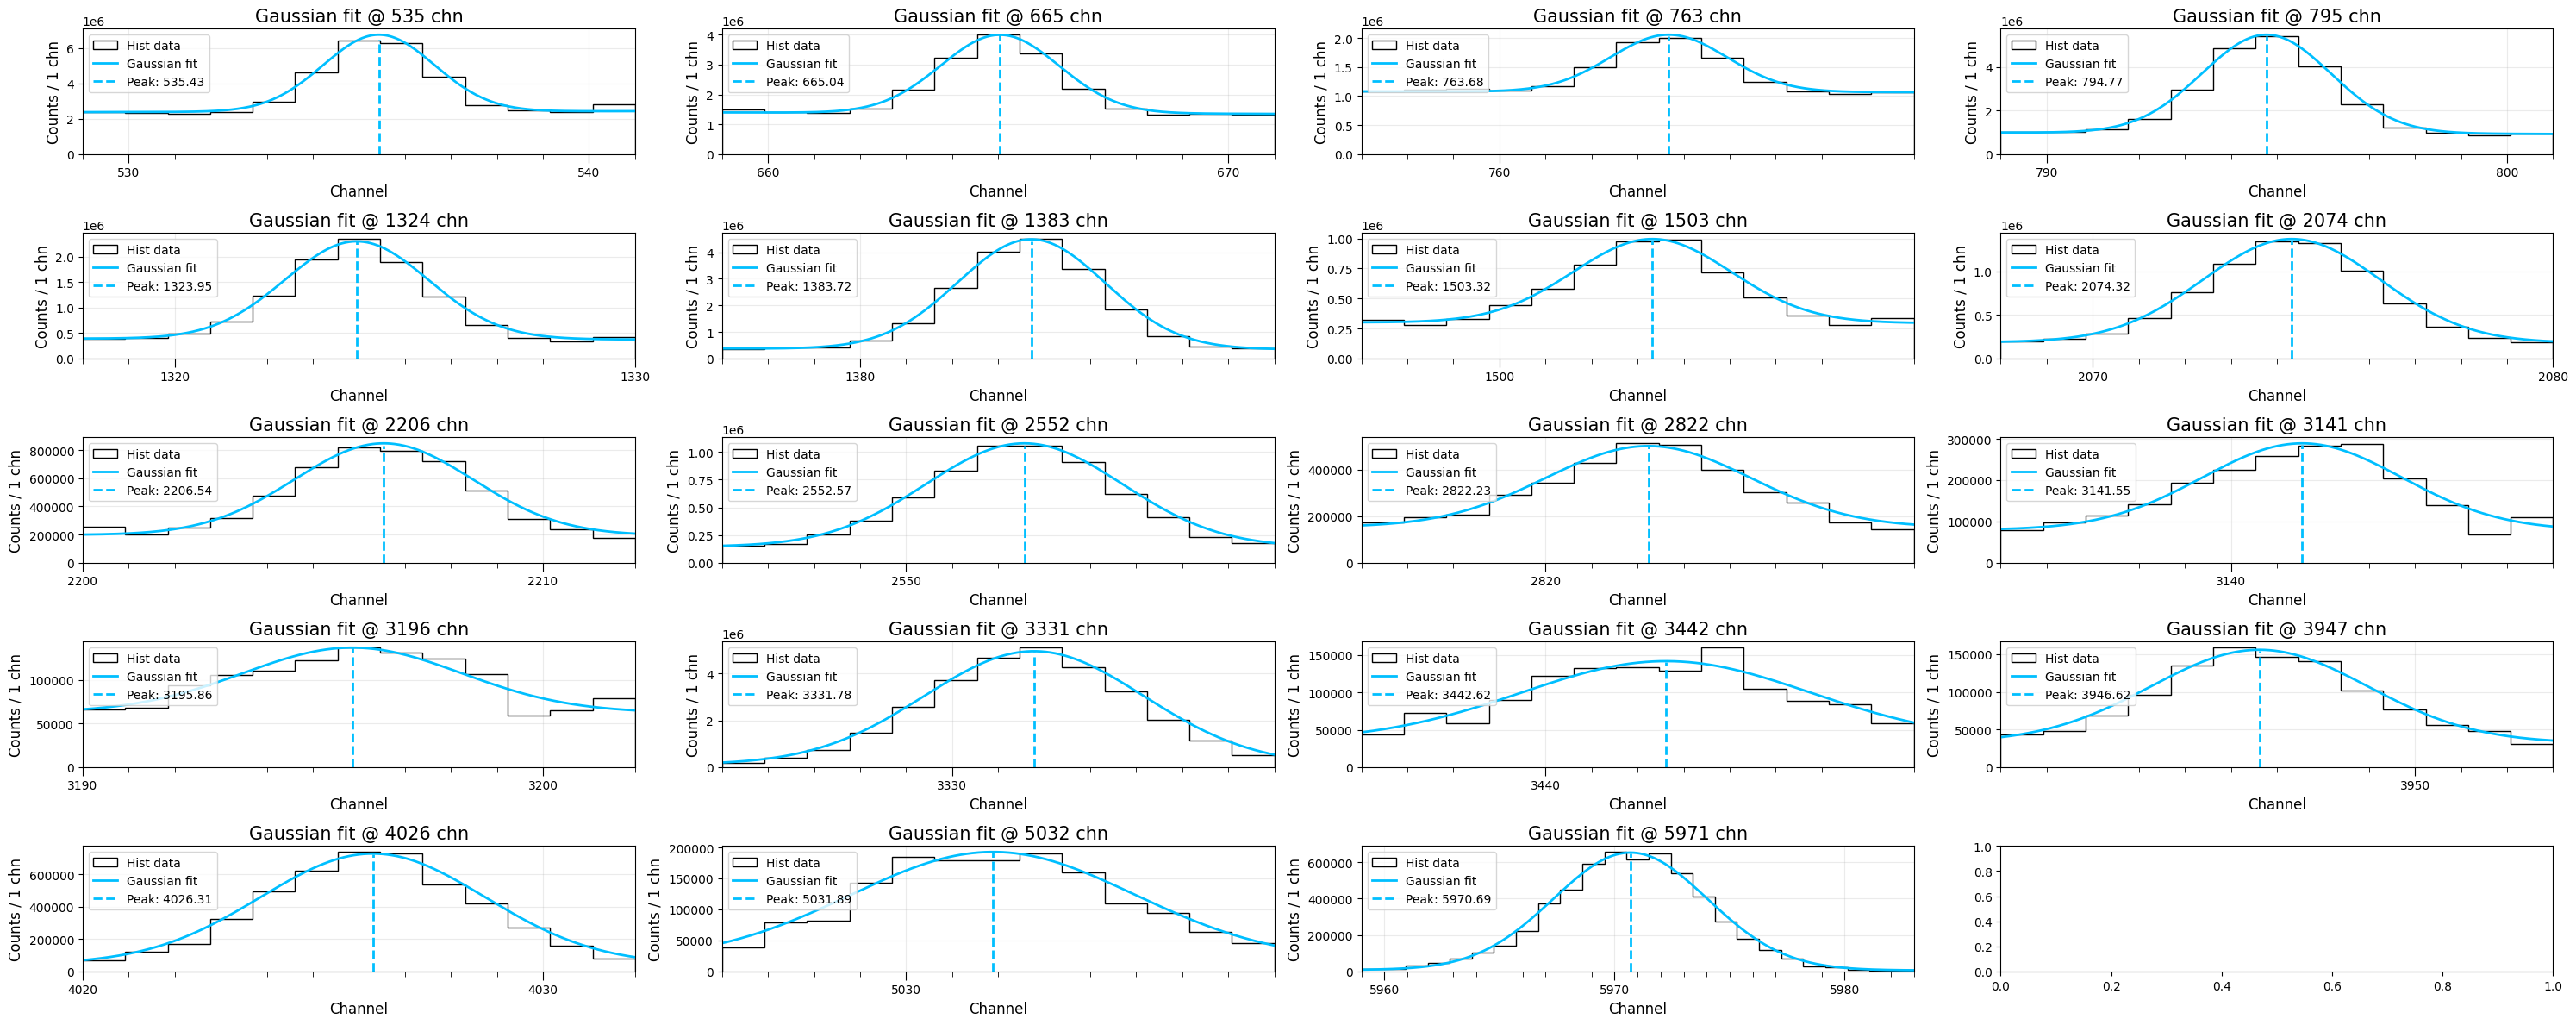

In [33]:
fig, axes = plt.subplots(5, 4, figsize=(30, 12))  # 1 riga, 3 colonne
E_chnt = [535, 665, 763 ,795,  1324, 1383, 1503,  2074 , 2206 ,2552, 2632, 2822, 3141, 3442, 3196,
        3331,  3947, 4026,  5032 ,5971]
#E_chn = [1158, 3331, 5970] 
popt_chn = []
popt_chn_err = []
axes = axes.flatten() 
for i, e in enumerate(E_chn):
   # print(i+1)
    ax = axes[i]
    if e == E_chn[-1]:
        dx =12
    else:
        dx = 6
    popt, err, _ = fit_func(spectrum_open, e, dx=dx, ax=ax)
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("new image/chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [34]:
len(E_kev)

3

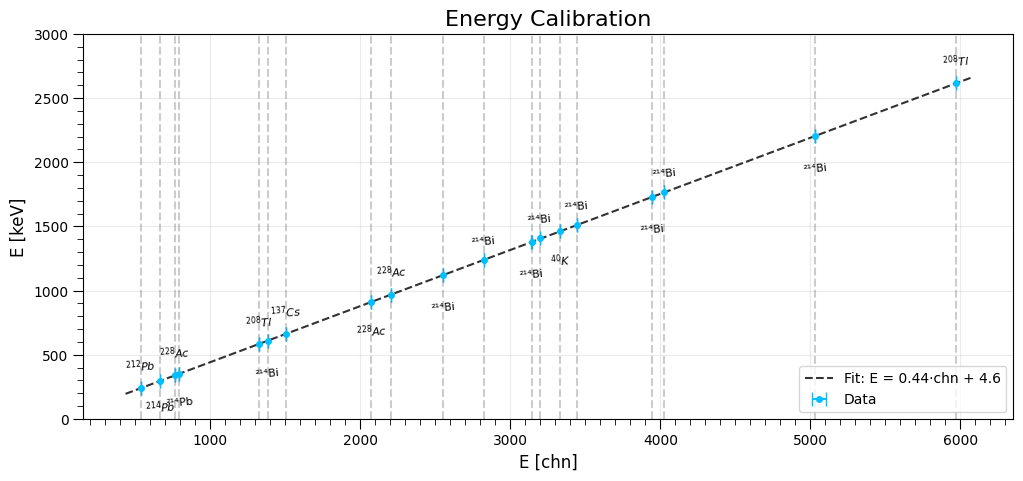

In [35]:
#E_kev = [511, 1460.830, 2614] #kev
E_kev_plot = [238.632, 338.32, 351.932, 295,  583, 609,  661.66,911.20, 969, 1120, 1238, 1377, 1407, 1460.83, 1509.228, 1729, 1764,2204, 2614]
E_chn = np.sort(E_chn_plot)
E_kev = np.sort(E_kev_plot)
popt_chn_arr = np.sort( popt_chn[:,1])


plt.figure(figsize=(12, 5))



dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.errorbar(popt_chn_arr,E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', markersize = 4, capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn_arr, E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_open = popt[0]
b_open = popt[1]

for i, (chn, iso) in enumerate(zip(popt_chn_arr, isotopes)):
    if chn < len(spectrum_open):  # Controllo sicurezza
        if i< 5:
            dy = 275
        else:
            dy = 300
        y_pos = E_kev[i] + (100 if i % 2 == 0 else -dy)  # Alterna altezza per evitare sovrapposizione
        x_pos = popt_chn_arr[i] + (-100 if i % 2 == 0 else 100) 
        plt.text(chn, y_pos, iso,
                 rotation=5, va='bottom', ha='center', fontsize=8, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', markersize = 0.05, alpha = 0.8)

plt.ylim(0, 3000)
plt.legend(fontsize = 10)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/E_cal_bkg", dpi=300, bbox_inches='tight')

In [36]:
 print(a_open , '+/-', perr[0])
print(b_open , '+/-', perr[1])

0.4371358934459243 +/- 0.00021073206503332518
4.560319029908137 +/- 0.6253469621055732


In [37]:
channels_open = np.arange(len(spectrum_open))         # x originale
energies_open = a_open * channels_open + b_open

In [38]:
122/170

0.7176470588235294

In [39]:
mask = (energies_open > 60) & (energies_open < 3000)
spectr_3Mev = spectrum_bkg[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_real_open), 'cps')

1157865321.599282
attività grezza 19828.49816075765 cps


In [40]:
E_kev

array([ 238.632,  295.   ,  338.32 ,  351.932,  583.   ,  609.   ,
        661.66 ,  911.2  ,  969.   , 1120.   , 1238.   , 1377.   ,
       1407.   , 1460.83 , 1509.228, 1729.   , 1764.   , 2204.   ,
       2614.   ])

In [41]:
dofs

[18, 18, 27]

In [42]:
len(E_kev)

19

[5.96066898e+06 2.38617195e+02 5.41242702e-01 9.81441669e+03
 1.04918438e+00]
[3.93374953e+05 1.20391968e-02 1.68062287e-02 1.87961863e+04
 4.59690222e+06]
[ 3.71136587e+06  2.95272538e+02  5.64689601e-01 -8.90718227e+03
  3.99871957e+06]
[1.11386667e+05 1.05095445e-02 1.32982586e-02 1.58157516e+04
 4.64341656e+06]
[ 1.34391297e+06  3.38392145e+02  5.47975322e-01 -2.73549430e+03
  2.00570696e+06]
[7.00934773e+04 1.95721751e-02 2.35924343e-02 1.02376310e+04
 3.45332625e+06]
[ 6.93431188e+06  3.51984199e+02  6.12065608e-01 -1.00000000e+04
  4.48485516e+06]
[1.34054292e+05 9.00674911e-03 1.02966644e-02 1.46778834e+04
 5.17628518e+06]
[ 3.22029698e+06  5.83312255e+02  6.76587572e-01 -3.33646391e+03
  2.34591548e+06]
[1.46398227e+05 1.66566387e-02 2.14814415e-02 1.70041150e+04
 9.88220968e+06]
[ 7.19884794e+06  6.09435023e+02  6.96937993e-01 -6.77411434e+03
  4.49506857e+06]
[1.96525451e+05 1.15435263e-02 1.42468252e-02 2.02276935e+04
 1.22846594e+07]
[ 1.46134910e+06  6.61714491e+02  8.080

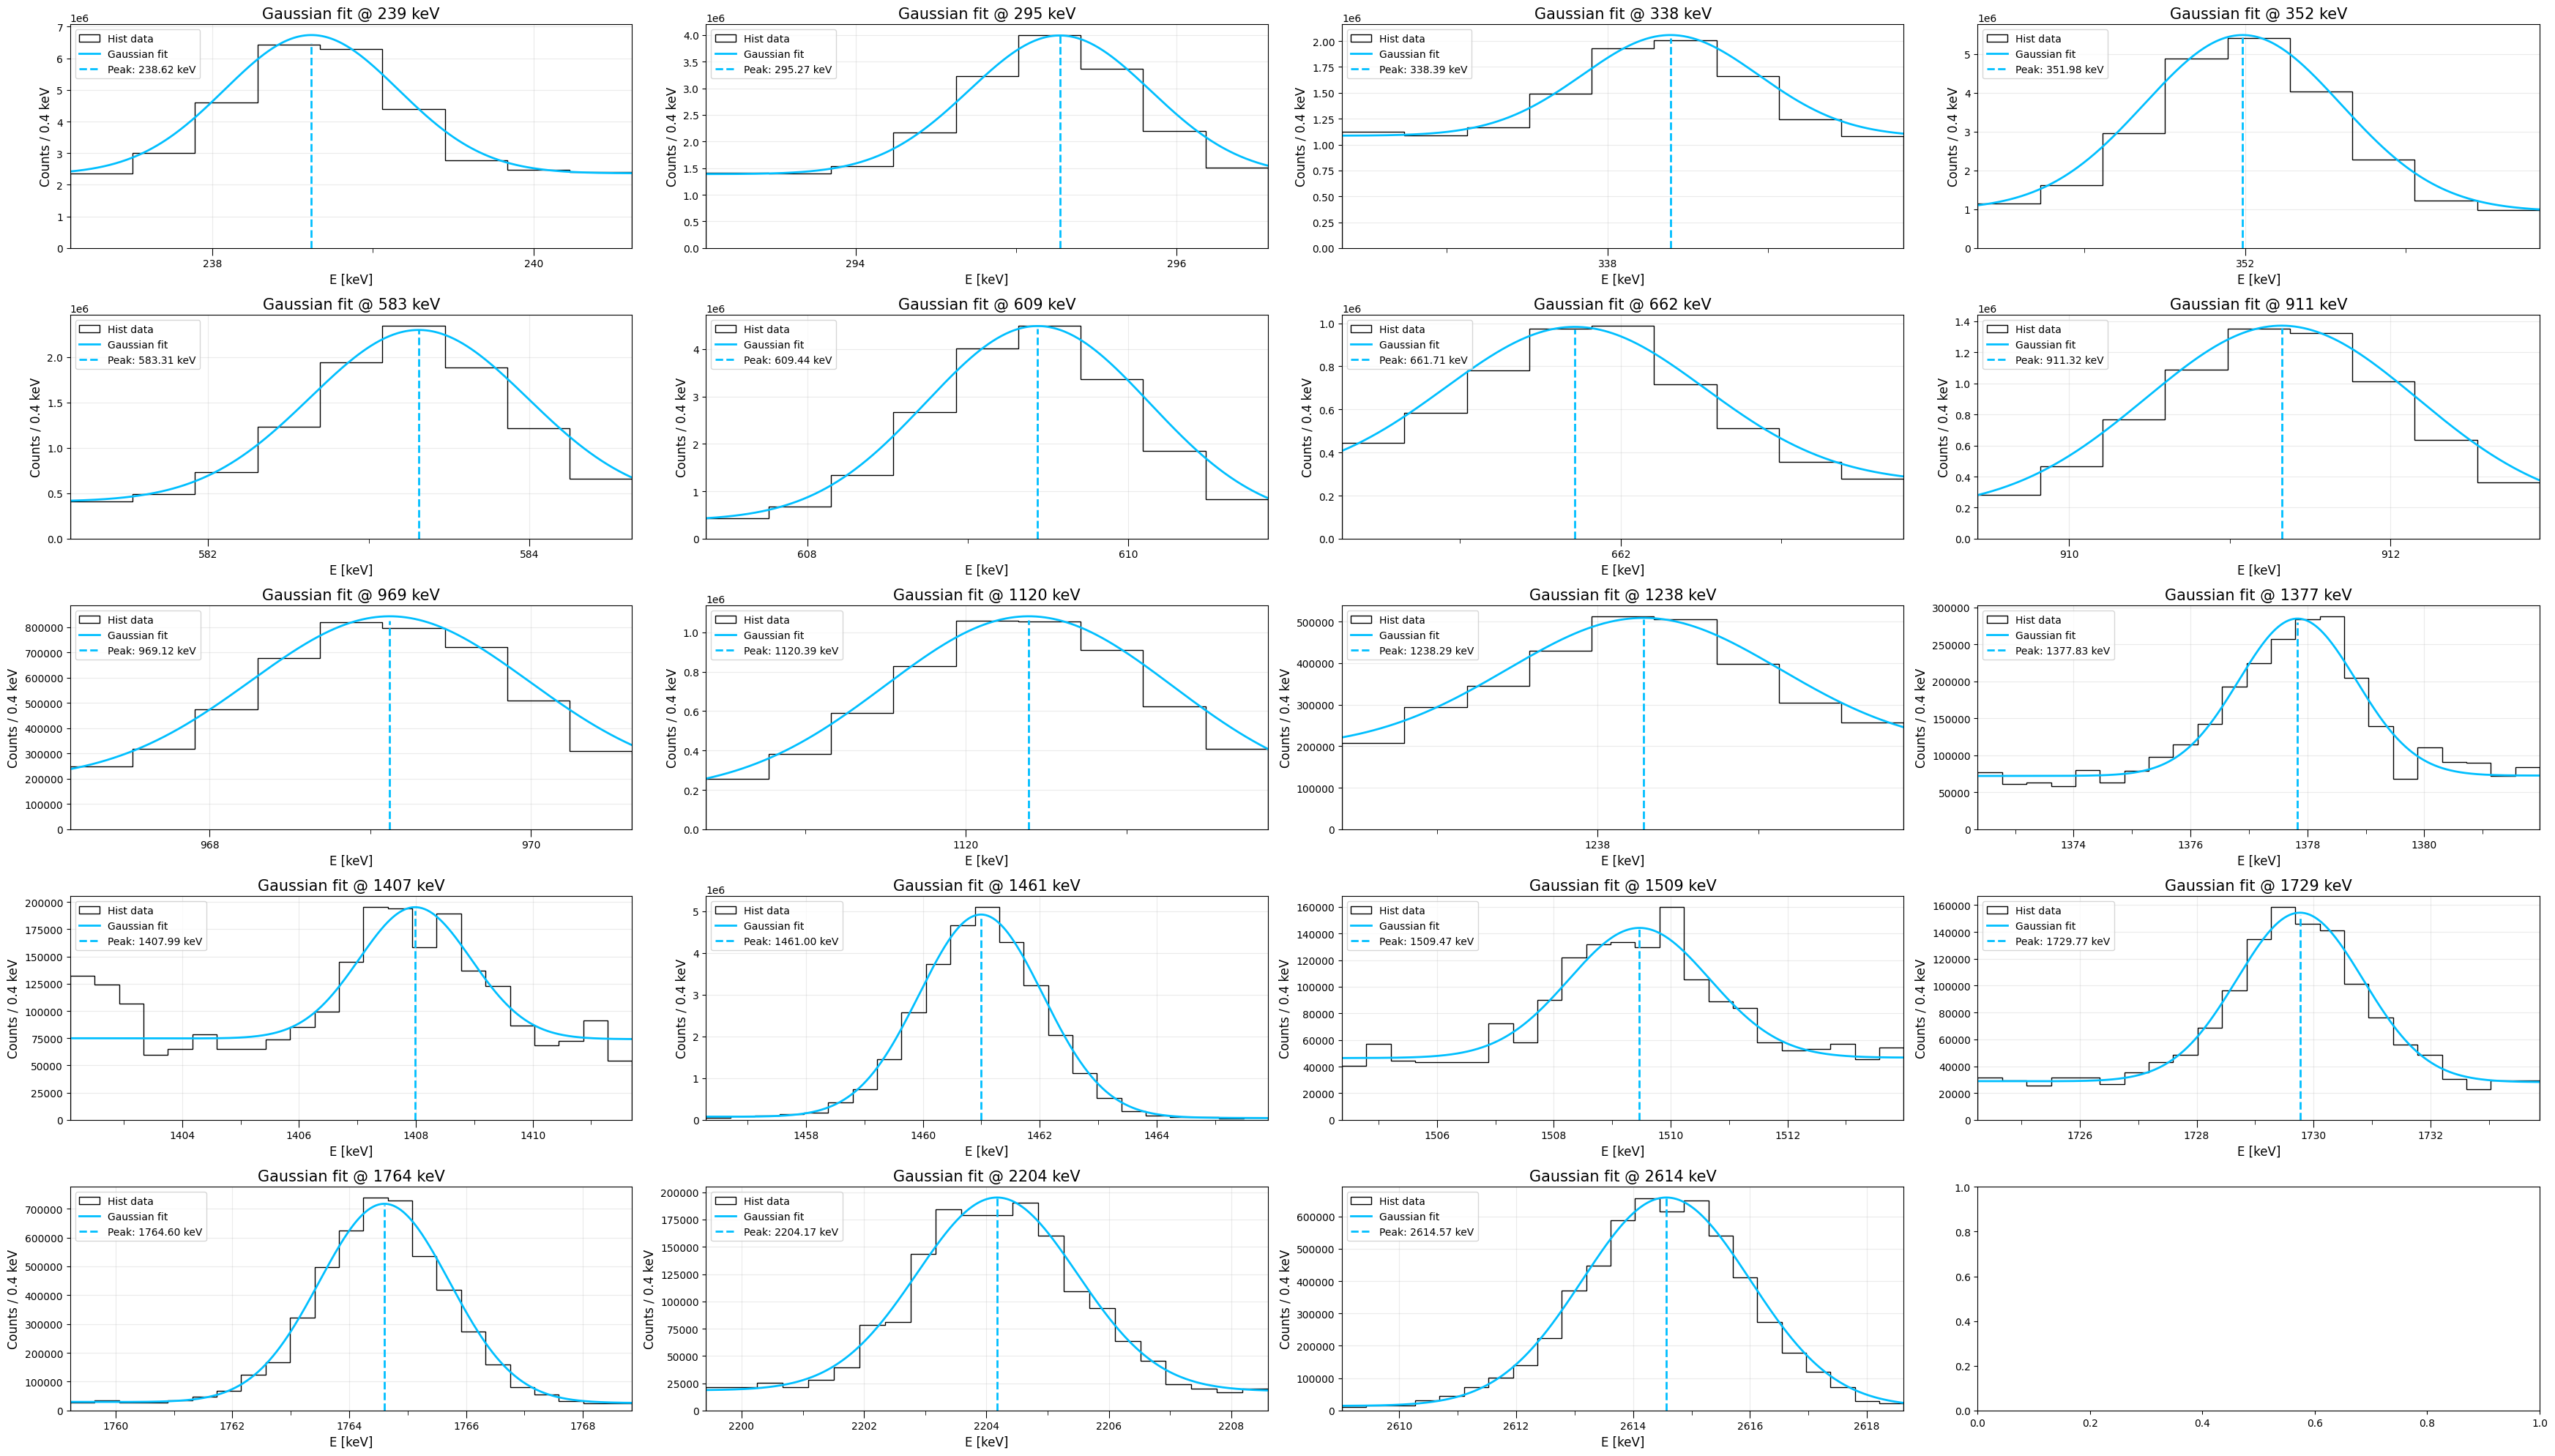

In [43]:
fig, axes = plt.subplots(5, 4, figsize=(35, 20))  # 1 riga, 3 colonne
#E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
axes = axes.flatten() 
for i, e in enumerate(E_kev):
    if i <=10:
        dx = 2
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_open, e, dx = dx, kev = True, energies = energies_open, ax=axes[i])
    print(popt)
    print(err)
    popt_kev.append(popt)
    popt_kev_err.append(err*2.5)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("HPGE open background/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [44]:
dofs

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 18, 18, 18, 18, 18, 18, 17, 18]

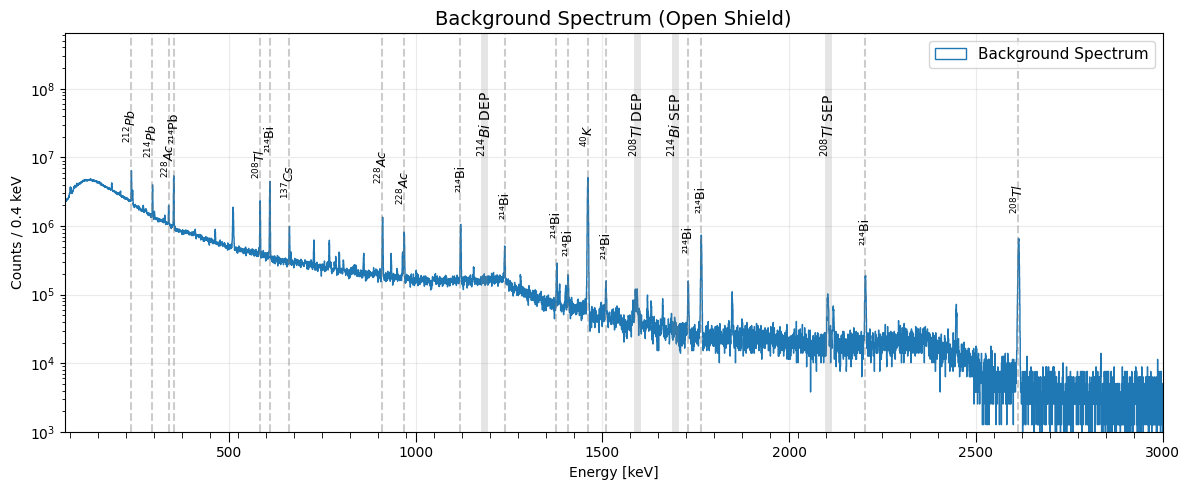

In [45]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

plt.figure(figsize=(12, 5))

# Configurazione assi x
dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma
bins = np.linspace(min(energies_open), max(energies_open), len(energies_open))
counts, bin_edges, _ = plt.hist(energies_open, bins=bins, weights=spectrum_open,
                                lw=0.5, histtype='step', label='Background Spectrum')
db = bin_edges[1] - bin_edges[0]

# Annotazioni isotopi
for i, (energy, iso) in enumerate(zip(E_kev, isotopes)):
    if min(energies_open) < energy < max(energies_open):
        # Trova il bin index più vicino per posizionare correttamente l'etichetta
        idx = np.abs(energies_open - energy).argmin()
        y_val = spectrum_open[idx]
        y_pos = y_val * (2.5if i % 2 == 0 else 3)
        plt.text(energy, y_pos, iso,
                 rotation=90, va='bottom', ha='center', size=9, color='black')
        plt.axvline(x=energy, color='gray', linestyle='--', alpha=0.4)
'''
plt.text(1173, 5e5, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=1173, color='gray', linestyle='--', alpha=0.4)

plt.text(1332, 5e5, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=1332, color='gray', linestyle='--', alpha=0.4)
'''
# Etichette assi e titolo
plt.xlabel('Energy [keV]', fontsize=10)
plt.ylabel(f'Counts / {db:.1f} keV', fontsize=10)
plt.title('Background Spectrum (Open Shield)', fontsize=14)

# DEP/SEP di 208-Tl
plt.vlines(popt_kev[-1]-511, 1000, np.max(spectrum_open)*100, color = 'grey', lw = 5, alpha = 0.2)
plt.vlines(popt_kev[-1]-511-511, 1000, np.max(spectrum_open)*100,  color = 'grey', lw = 5, alpha = 0.2)
plt.text(2615-511, 1e7, r"$^{208}Tl$ SEP",rotation=90, va='bottom', ha='center', size=10, color='black')
plt.text(2615-511-511, 1e7, r"$^{208}Tl$ DEP",rotation=90, va='bottom', ha='center', size=10, color='black')

# DEP/SEP di 214-Bi 2204 keV
plt.vlines(popt_kev[-2]-511, 1000, np.max(spectrum_open)*100,  color = 'grey', lw = 5, alpha = 0.2)
plt.vlines(popt_kev[-2]-511-511, 1000, np.max(spectrum_open)*100,  color = 'grey', lw = 5, alpha = 0.2)
plt.text(2204-511, 1e7, r"$^{214}Bi$ SEP",rotation=90, va='bottom', ha='center', size=10, color='black')
plt.text(2206-511-511, 1e7, r"$^{214}Bi$ DEP",rotation=90, va='bottom', ha='center', size=10, color='black')





# Limiti assi
plt.xlim(60, 3000)
plt.ylim(1e3, np.max(spectrum_open)*100)  # log scale → evitare zero

# Scala logaritmica y
plt.yscale('log')

# Legenda, griglia e salvataggio
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.25)

plt.tight_layout()
plt.savefig("new image/spectrum_bkg_kev_open.png", dpi=300, bbox_inches='tight')


In [50]:
mask = (energies_open > 60) & (energies_open < 3000)

spectr_3Mev = spectrum_open[mask]
cps_total = np.sum(spectr_3Mev)/(t_real_open)

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 47203 cps


In [51]:
15084/47203  

0.31955596042624407

In [52]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -0.49
✅ p > 0.05 
p-value = 0.7090
t = 10.37
✅ p > 0.05 
p-value = 0.0612
t = 1.47
✅ p > 0.05 
p-value = 0.3794
t = 2.32
✅ p > 0.05 
p-value = 0.2593
t = 7.50
✅ p > 0.05 
p-value = 0.0844
t = 15.07
❌ p < 0.05 
p-value = 0.0422
t = 0.35
✅ p > 0.05 
p-value = 0.7867
t = 2.51
✅ p > 0.05 
p-value = 0.2414
t = 0.91
✅ p > 0.05 
p-value = 0.5284
t = 7.00
✅ p > 0.05 
p-value = 0.0903
t = 1.46
✅ p > 0.05 
p-value = 0.3823
t = 4.20
✅ p > 0.05 
p-value = 0.1489
t = 2.52
✅ p > 0.05 
p-value = 0.2409
t = 5.49
✅ p > 0.05 
p-value = 0.1146
t = 1.00
✅ p > 0.05 
p-value = 0.4999
t = 8.23
✅ p > 0.05 
p-value = 0.0770
t = 12.18
✅ p > 0.05 
p-value = 0.0521
t = 1.41
✅ p > 0.05 
p-value = 0.3932
t = 7.67
✅ p > 0.05 
p-value = 0.0825


incertezza grandi solo 3 punti del fit
paramters: [6.68224115e-02 6.18902280e-17]
Errori: [2.71598381e-03 1.67045684e+01]


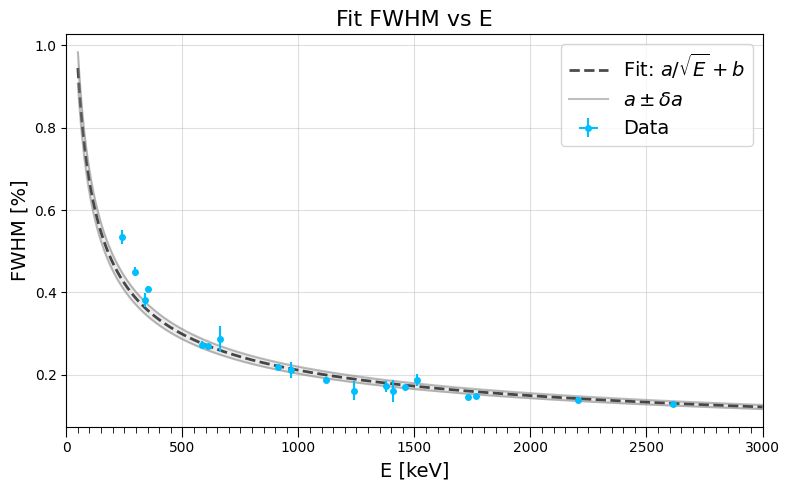

In [53]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]/2.5
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_open_res = np.sqrt(np.diag(pcov))

a_open_res = popt[0]
b_open_res = popt[1]

print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))


dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, a_open_res, b_open_res)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, a_open_res + perr_open_res[0], b_open_res) * 100
lower_curve = fhwm_func(E_fit, a_open_res - perr_open_res[0], b_open_res) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("new image/FWHM open baclground", dpi=300, bbox_inches='tight')
plt.show()

# Uranium Spectrum

In [54]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u

In [55]:
E_chn_U = [ 415, 543,665,794, 1382, 1746,2125, 2550,4024]
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]
E_kev_U = [ 186.221, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]

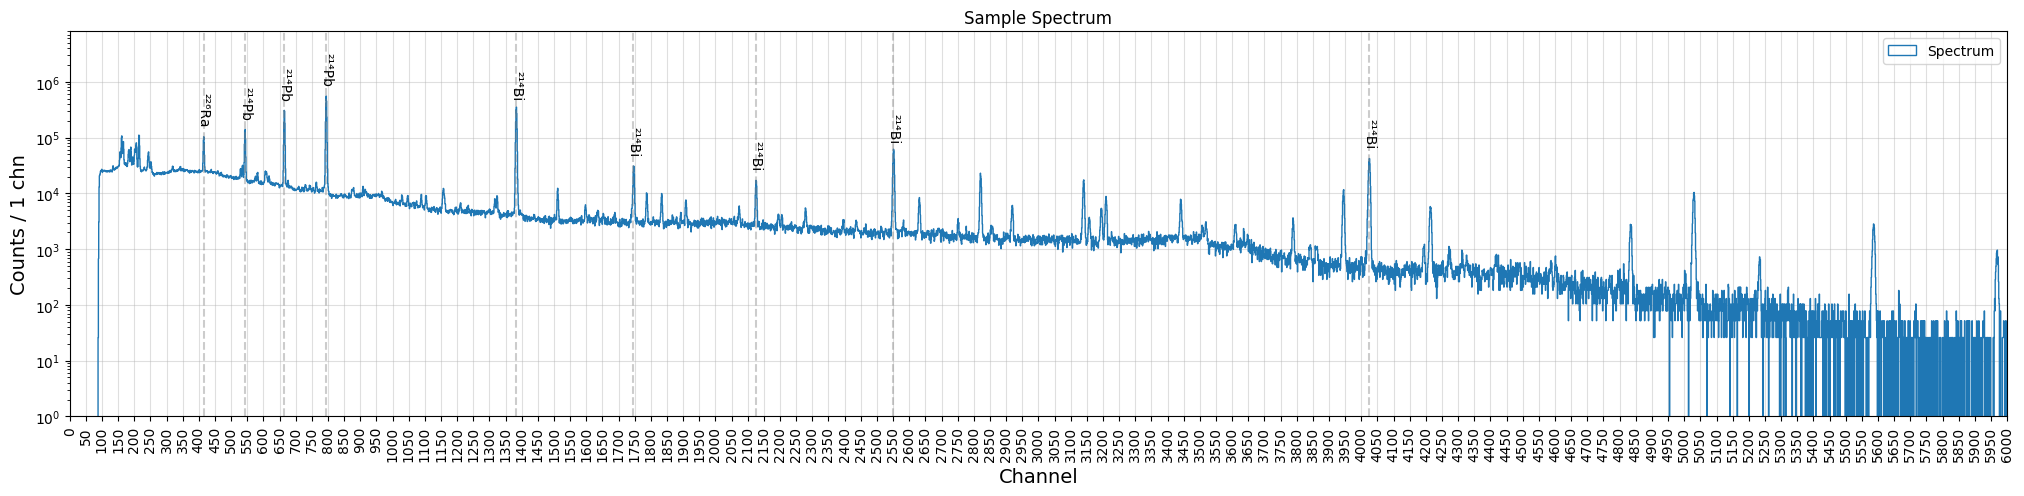

In [56]:
# Canali dei picchi identificati nello spettro
#E_chn_U = [415, 543, 665, 794, 1382, 1746, 2125, 4024]
# Isotopi corrispondenti
isotopes = ['²²⁶Ra', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Bi', '²¹⁴Bi','²¹⁴Bi','²¹⁴Bi',  '²¹⁴Bi']

plt.figure(figsize=(25, 5))
#plt.plot(spectrum_U, lw=0.5, label='Spectrum')

chn =  np.arange(len(spectrum_U))
bins =  np.linspace(min(chn), max(chn), len(chn), +1 )
counts, bin_edge, _ = plt.hist(chn, bins = bins, weights = spectrum_U,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]
# Etichette degli isotopi sui picchi
for chn, iso in zip(E_chn_U, isotopes):
    plt.text(chn, spectrum_U[chn]*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
chn =  np.arange(len(spectrum_U))
plt.xticks(np.arange(min(chn), max(chn), 50), rotation=90)
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
#plt.title('Uranium Spectrum', size=15)
#plt.xlim(0, 6000)
plt.xlim(0, 6000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("HPGe images/238U/ 238U_channel", dpi=300, bbox_inches='tight')
plt.show()

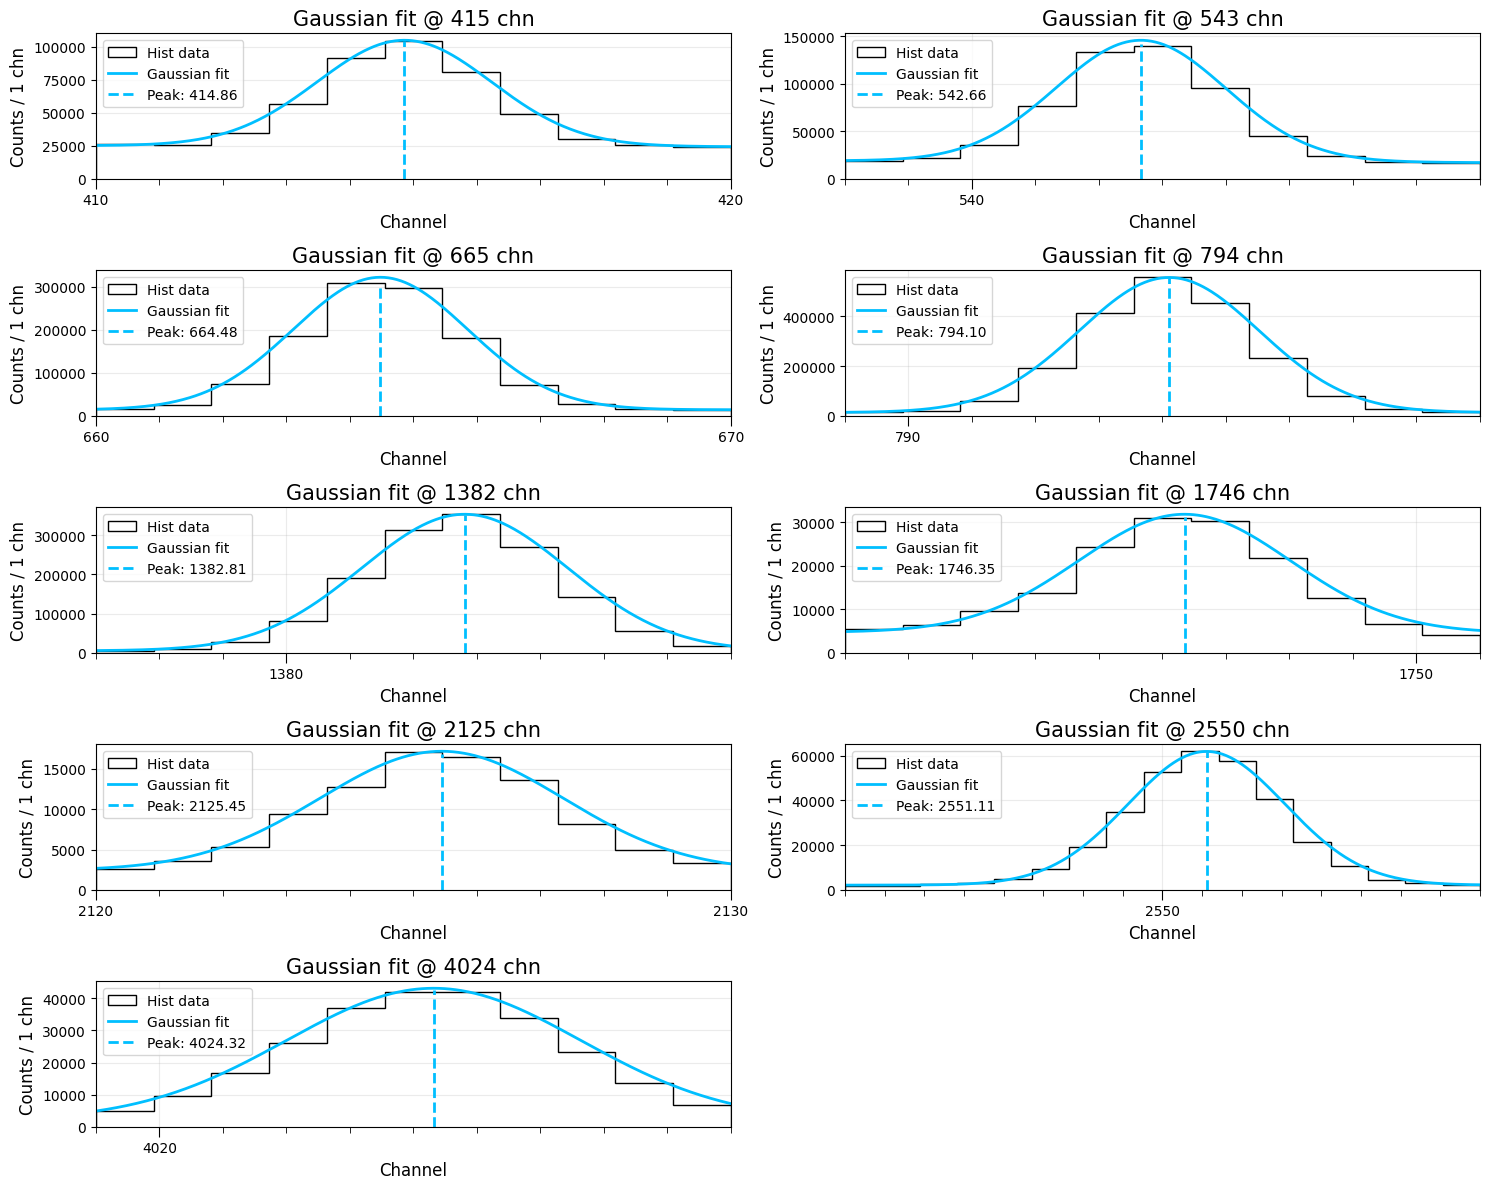

In [57]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_U):
    ax = axes[i]
    dx = 8 if i == 7 else 5
    popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
    popts_U.append(popt)
    err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_U), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [58]:
E_kev_U

[186.221, 242, 295.224, 351.932, 609.312, 768.356, 934.061, 1120, 1764.494]

Uncertainty on a: 0.000211, on b: 0.63


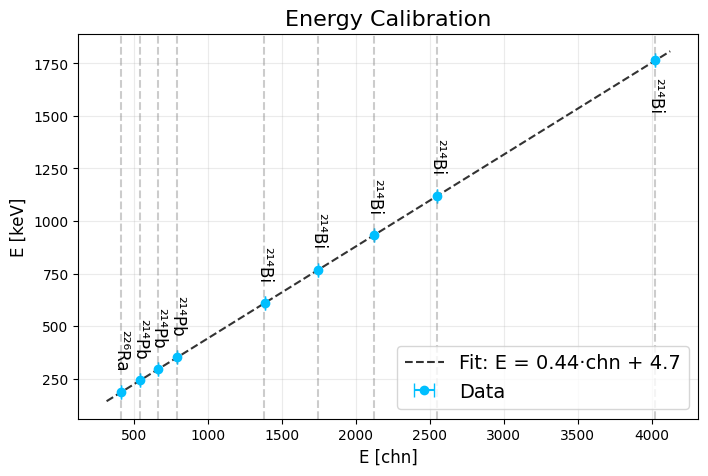

In [59]:
mu_chn = popts_U[:, 1]
mu_chn_err = err_U[:, 1]
plt.figure(figsize=(8, 5))
plt.errorbar( mu_chn,E_kev_U, xerr=mu_chn_err, fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_U, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f"Uncertainty on a: {perr[0]:.6f}, on b: {perr[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for idx, (chn, iso) in enumerate(zip(E_chn_U, isotopes)):
    if idx == 8:
        plt.text(chn, E_chn_U[idx]*a + b - 250 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    else:
        plt.text(chn, E_chn_U[idx]*a + b + 100 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
plt.legend(fontsize = 14)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("HPGe images/238U/E_ene_cal", dpi=300, bbox_inches='tight')

In [60]:
print('b', b)
print('b bkg', b_bkg)
print('a', a)
print('a bkg', a_bkg)

b 4.707398056912284
b bkg 4.682977688622721
a 0.4372576566898085
a bkg 0.43738294846886144


In [61]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

In [62]:
for i in range(0,len(energies)):
    if spectrum_U[i] != 0:
        print(f' Energy threshold at {energies[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.19 keV


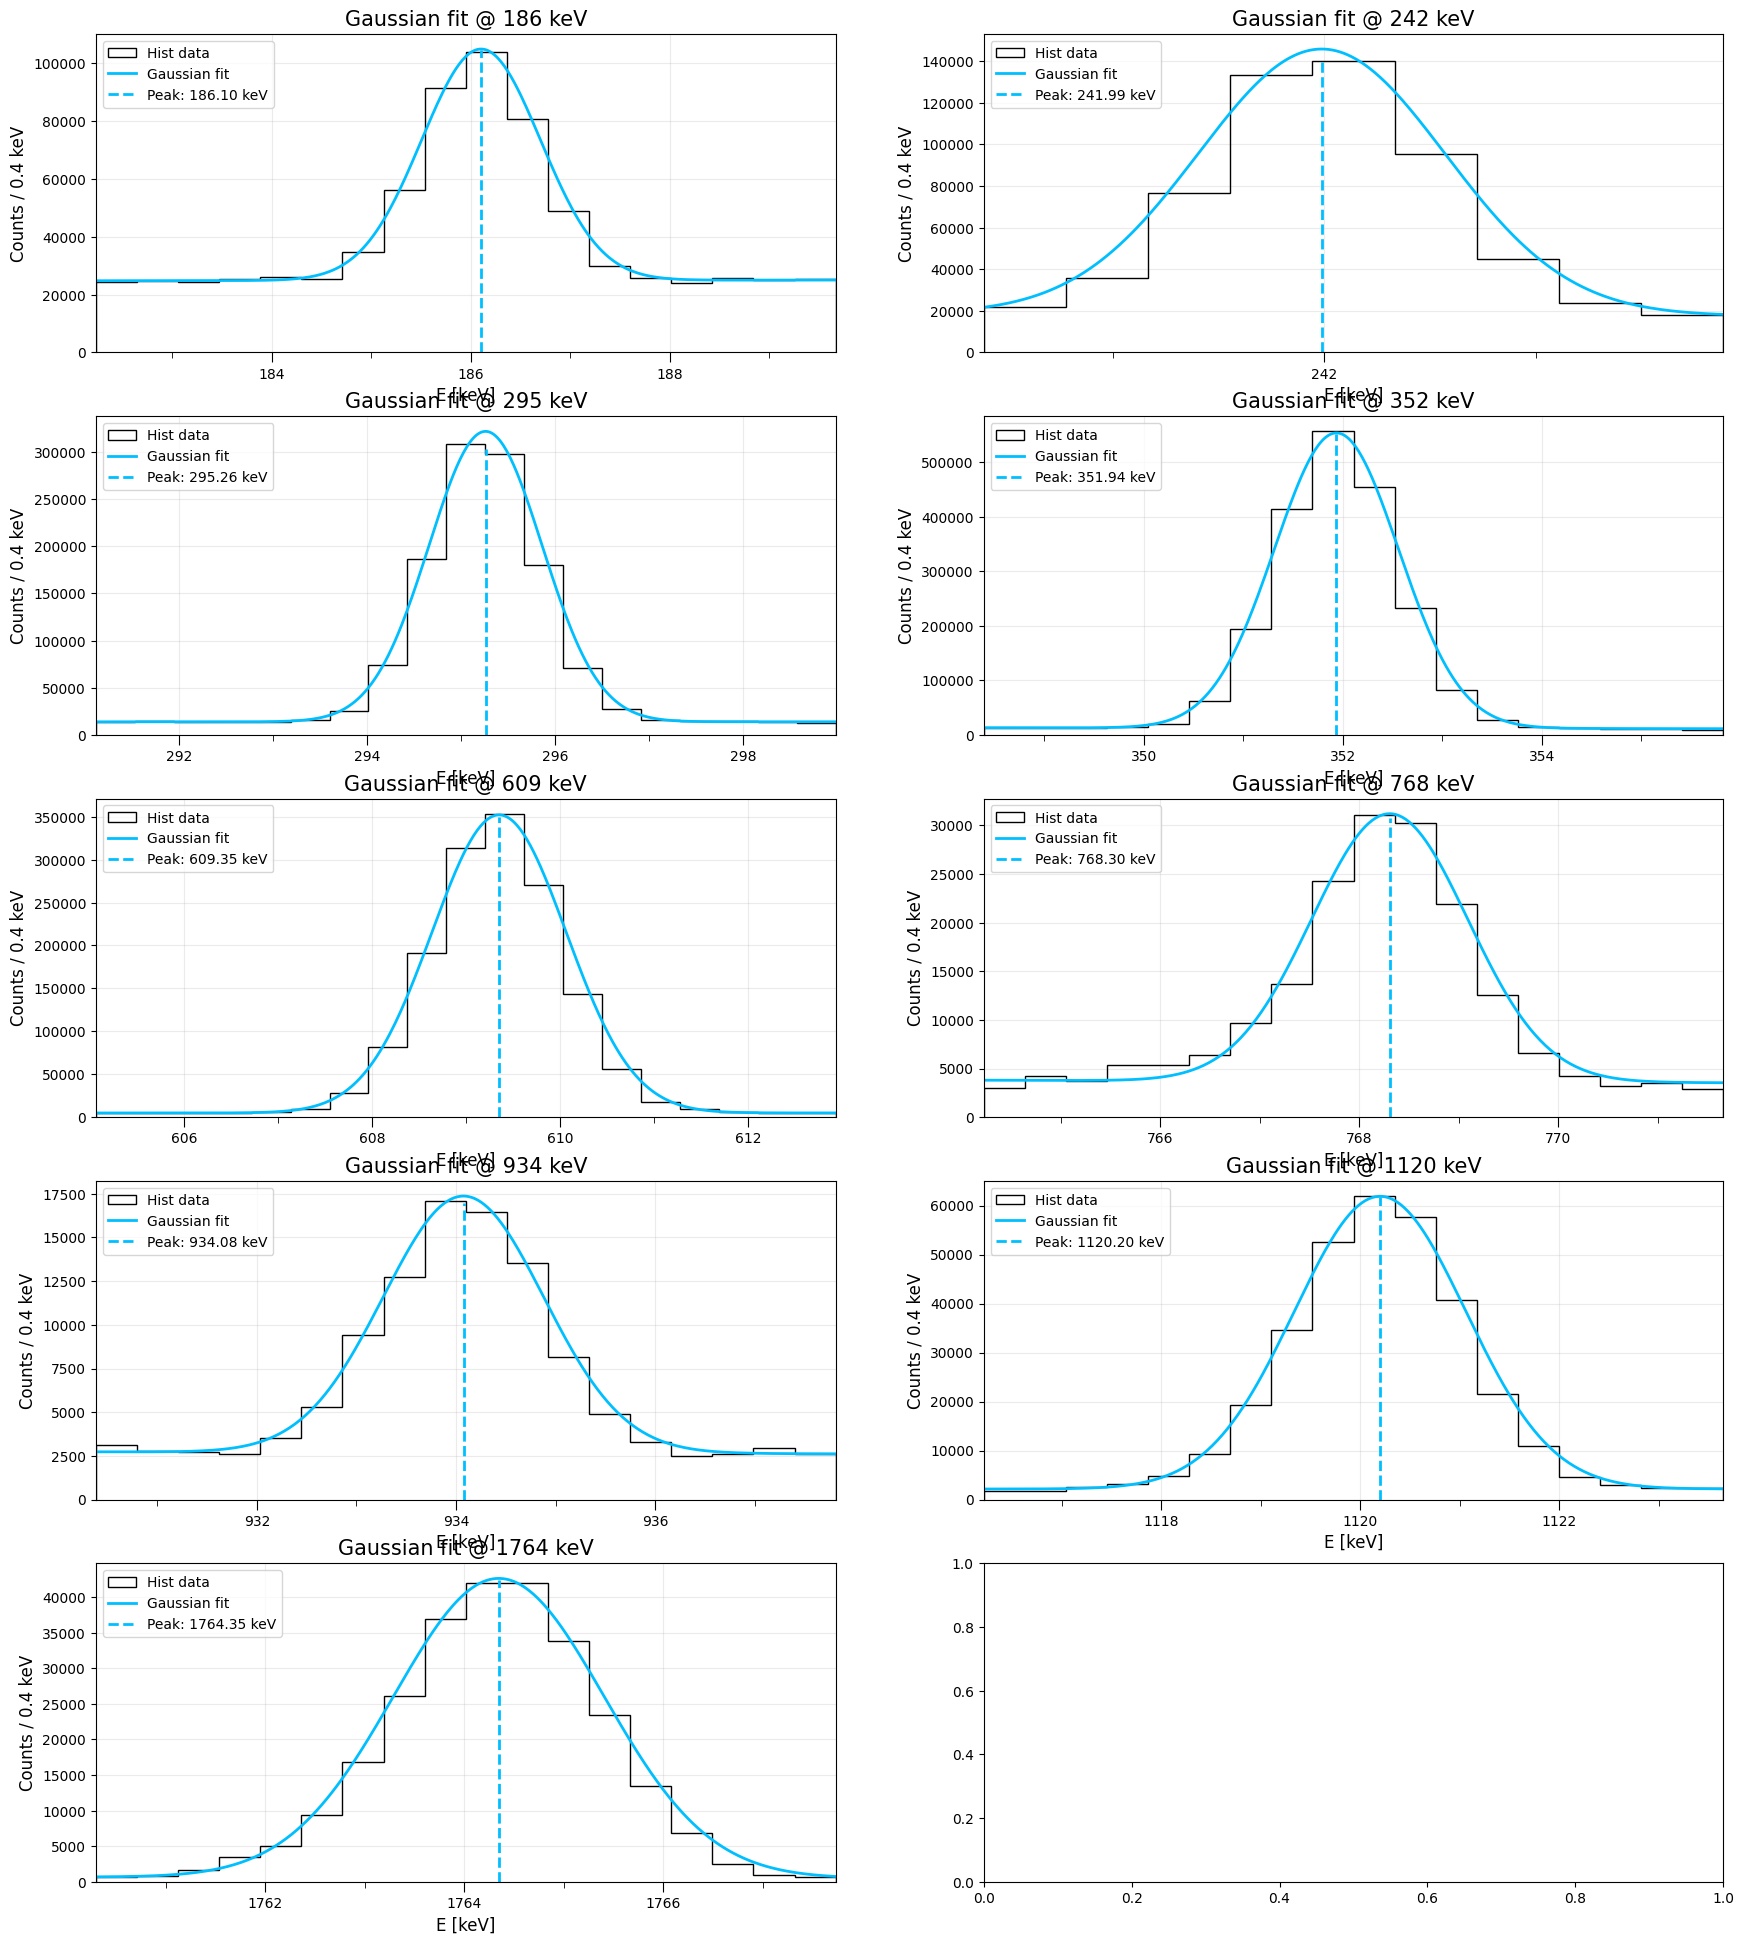

In [63]:
popts_U_kev = []
err_U_kev = []
dofs = []
fig, axes = plt.subplots(5,2, figsize=(21, 24))  # 1 riga, 3 colonne
for i, e in enumerate(E_kev_U):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    if e == E_kev_U[1]:
        dx = 2
    else:
        dx = 4
    popt, err, dof = fit_func(spectrum_U, e, dx =dx, kev = True, energies = energies, ax = ax)
    popts_U_kev.append(popt)
    err_U_kev.append(err*5)
    dofs.append(dof)
popts_U_kev = np.vstack(popts_U_kev)
err_U_kev = np.vstack(err_U_kev)

plt.savefig("HPGe images/ energy_peak_fit_U", dpi=300, bbox_inches='tight')

In [64]:
dofs

[13, 4, 14, 13, 14, 13, 13, 13, 13]

In [65]:
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
for i in range(0, len(mu_kev)):
    mu_theo = E_kev_U[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -3.34
✅ p > 0.05 
p-value = 0.1853
t = -0.35
✅ p > 0.05 
p-value = 0.7843
t = 1.71
✅ p > 0.05 
p-value = 0.3365
t = 0.22
✅ p > 0.05 
p-value = 0.8641
t = 1.23
✅ p > 0.05 
p-value = 0.4344
t = -0.29
✅ p > 0.05 
p-value = 0.8176
t = 0.15
✅ p > 0.05 
p-value = 0.9057
t = 3.24
✅ p > 0.05 
p-value = 0.1907
t = -1.26
✅ p > 0.05 
p-value = 0.4259


incertezza grandi solo 3 punti del fit
paramters: [7.57877357e-02 1.84233408e-16]
Errori: [6.79574835e-03 1.07997918e+02]


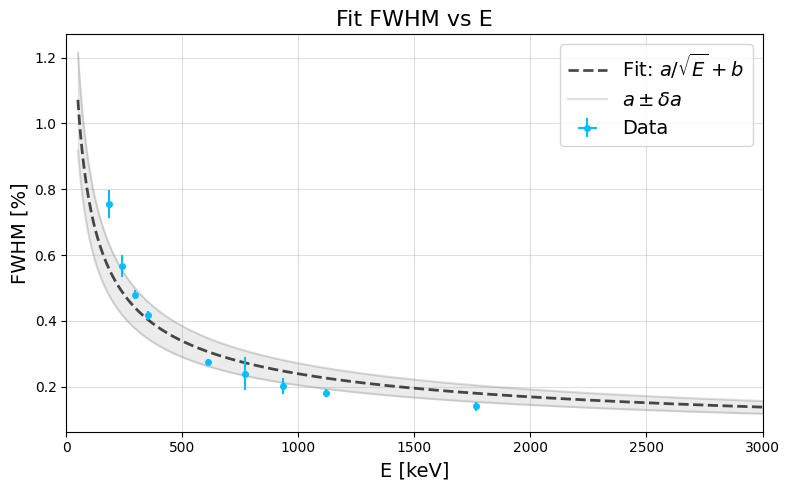

In [66]:
sigma=popts_U_kev[:,2]
sigma_err_kev = err_U_kev[:,2]
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,1])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',     
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')
upper_curve = fhwm_func(E_fit, popt[0] + 1.5*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 1.6*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("HPGe images/238U/ FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

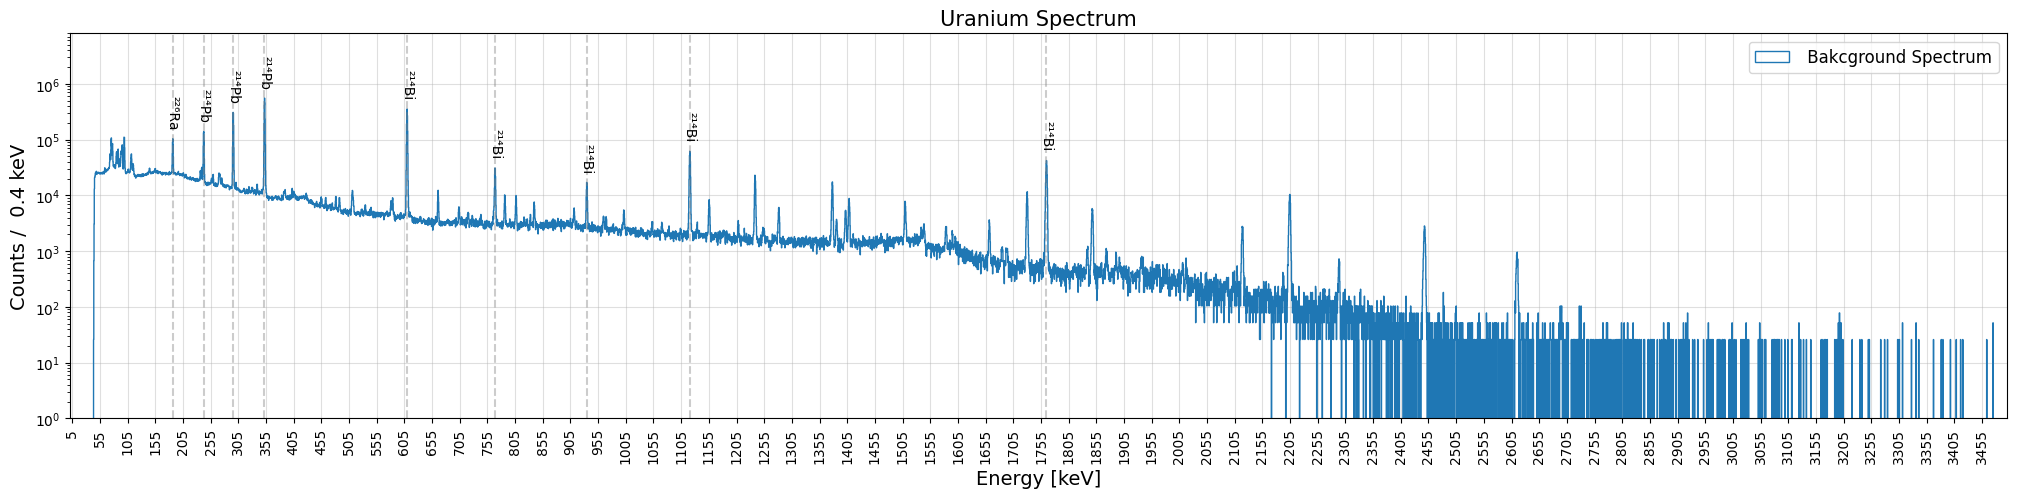

In [67]:
plt.figure(figsize=(25, 5))
bins = np.linspace(min(energies), max(energies), len(energies))
counts, bin_edge, _ = plt.hist(energies, bins = bins, weights = spectrum_U, lw = 0.25,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]-bin_edge[0]
# Colori per ogni fit
colors = plt.cm.cool(np.linspace(0, 1, len(popts_U_kev)))

# Fit gaussiani

for E, iso in zip(mu_kev, isotopes):
    y = np.interp(E, energies, spectrum_U)
    plt.text(E, y*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=E, color='gray', linestyle='--', alpha=0.4)
    
plt.title('Sample Spectrum')
plt.xlabel('Energy [keV]', size=14)
plt.ylabel(f'Counts / {db : .1f} keV', size=14)
plt.title('Uranium Spectrum', size=15)
plt.xticks(np.arange(min(energies), max(energies), 50), rotation=90)
plt.xlim(0, 8000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.xlim(0, 3500)
#plt.ylim(0, max(spectrum))
plt.yscale('log')
plt.legend(fontsize = 12)
plt.savefig("HPGe images/238U/U_energy_spectrum", dpi=300, bbox_inches='tight')
plt.show()

# Analis prova

In [68]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625


In [69]:
E_chn_U = [ 415, 528.9, 543,665,794,1320,
            1382, 1746,2125, 2551,4024,
            1510, 1787.4, 1832.14, 2630, 2820.2, 2918.41, 3140,
            3440.86, 3788, 3944, 4213,4835,5030,5234, 5586]
'''
E_chn_U = [ 415, 528.9, 543,665,794, 1382, 1746,2125, 2551,4024,
            1510, 1787.4, 1832.14, 2630, 2820.2, 2918.41, 3140,
            3440.86, 3944,  4835, 5030]
'''
E_chn_U = np.sort(E_chn_U)
'''
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120.287,  1764.494,
             665.45, 785.35, 806.174, 1155.190, 1238.11, 1280.960, 1377.669,  1509.228, 1729.595, 2118.55,2204 ]
'''
E_kev_U = [ 185.712, 236, 242,295.224, 351.932, 580.13,
            609.312,768.356, 934.061, 1120.287,  1764.494,
             665.45, 785.356, 806.174, 1155.190, 1238.11, 1280.960, 1377.669, 
            1509.228, 1661.28, 1729.595,1847.42, 2118.55,
            2204 , 2293.4, 2447.86]
E_kev_U = np.sort(E_kev_U)

In [70]:
np.sort(E_kev_U)

array([ 185.712,  236.   ,  242.   ,  295.224,  351.932,  580.13 ,
        609.312,  665.45 ,  768.356,  785.356,  806.174,  934.061,
       1120.287, 1155.19 , 1238.11 , 1280.96 , 1377.669, 1509.228,
       1661.28 , 1729.595, 1764.494, 1847.42 , 2118.55 , 2204.   ,
       2293.4  , 2447.86 ])

In [71]:
E_ann_chn = [1156]
E_ann_kev = [511]

In [72]:
E_chn_th = [ 534.8 ,
            763.0685714285713,
            1907.9600,
            2072.517714285714,
            2194.5565714285717,
           5968.2]
E_kev_th = [ 238.632, 338.32, 837.8, 911.204, 968.971, 2614]

In [73]:
E_chn_tot = np.concatenate((E_ann_chn , E_chn_U, E_chn_th))
E_kev_tot = np.concatenate((E_ann_kev, E_kev_U, E_kev_th))

In [74]:

np.sort(E_kev_U)

array([ 185.712,  236.   ,  242.   ,  295.224,  351.932,  580.13 ,
        609.312,  665.45 ,  768.356,  785.356,  806.174,  934.061,
       1120.287, 1155.19 , 1238.11 , 1280.96 , 1377.669, 1509.228,
       1661.28 , 1729.595, 1764.494, 1847.42 , 2118.55 , 2204.   ,
       2293.4  , 2447.86 ])

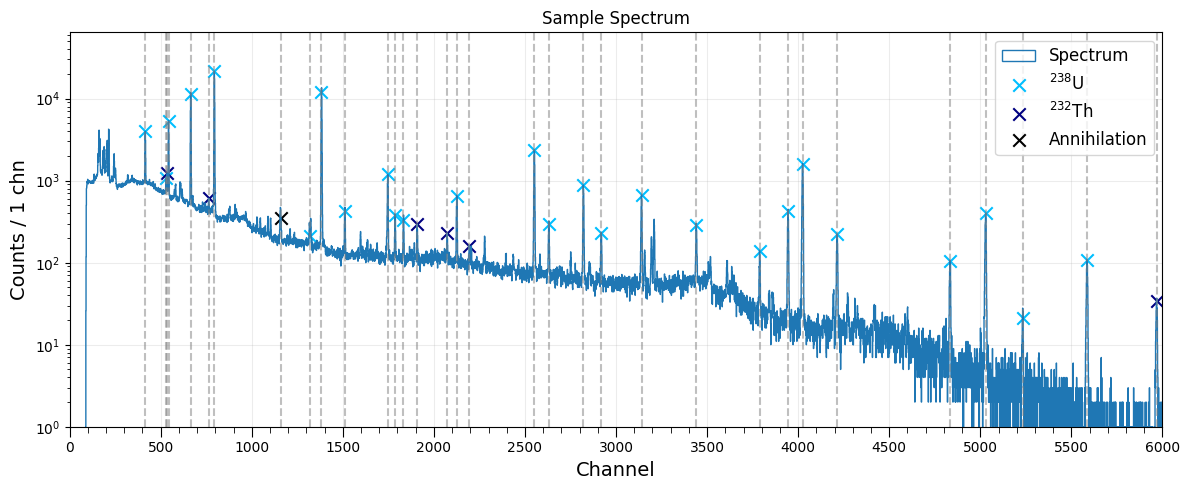

In [75]:

plt.figure(figsize=(12, 5))

dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma dello spettrot
chn = np.arange(len(spectrum_U))
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edge, _ = plt.hist(
    chn,
    bins=bins,
    weights=spectrum_U,
    histtype='step',
    label='Spectrum'
)

db = bin_edge[1] - bin_edge[0]

# Flag per visualizzare etichette in legenda solo una volta
plotted_U = False
plotted_Th = False
plotted_ann = False

# Picchi 238U
for ch in E_chn_U:
    ch_idx = int(round(ch))
    if 0 <= ch_idx < len(spectrum_U):
        y = spectrum_U[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='deepskyblue', marker='x', s=80,
                    label=r'$^{238}$U' if not plotted_U else "")
        plotted_U = True

# Picchi 232Th
for ch in E_chn_th:
    ch_idx = int(round(ch))
    if 0 <= ch_idx < len(spectrum_U):
        y = spectrum_U[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='navy', marker='x', s=80,
                    label=r'$^{232}$Th' if not plotted_Th else "")
        plotted_Th = True




ch_ann = 1160
ch_idx = np.searchsorted(bin_edge, ch_ann) - 1
if 0 <= ch_idx < len(counts):
    y = counts[ch_idx]
    plt.axvline(x=ch_ann, color='grey', linestyle='--', alpha=0.5)
    plt.scatter(ch_ann, y, color='black', marker='x', s=80, label='Annihilation')

# Labels e stile grafico
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
plt.xlim(0, 6000)
plt.ylim(1, max(spectrum_U)*3)
plt.yscale('log')
plt.grid(alpha=0.24)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new image/238U_channel", dpi=300, bbox_inches='tight')
plt.show()


## len(E_kev_tot )

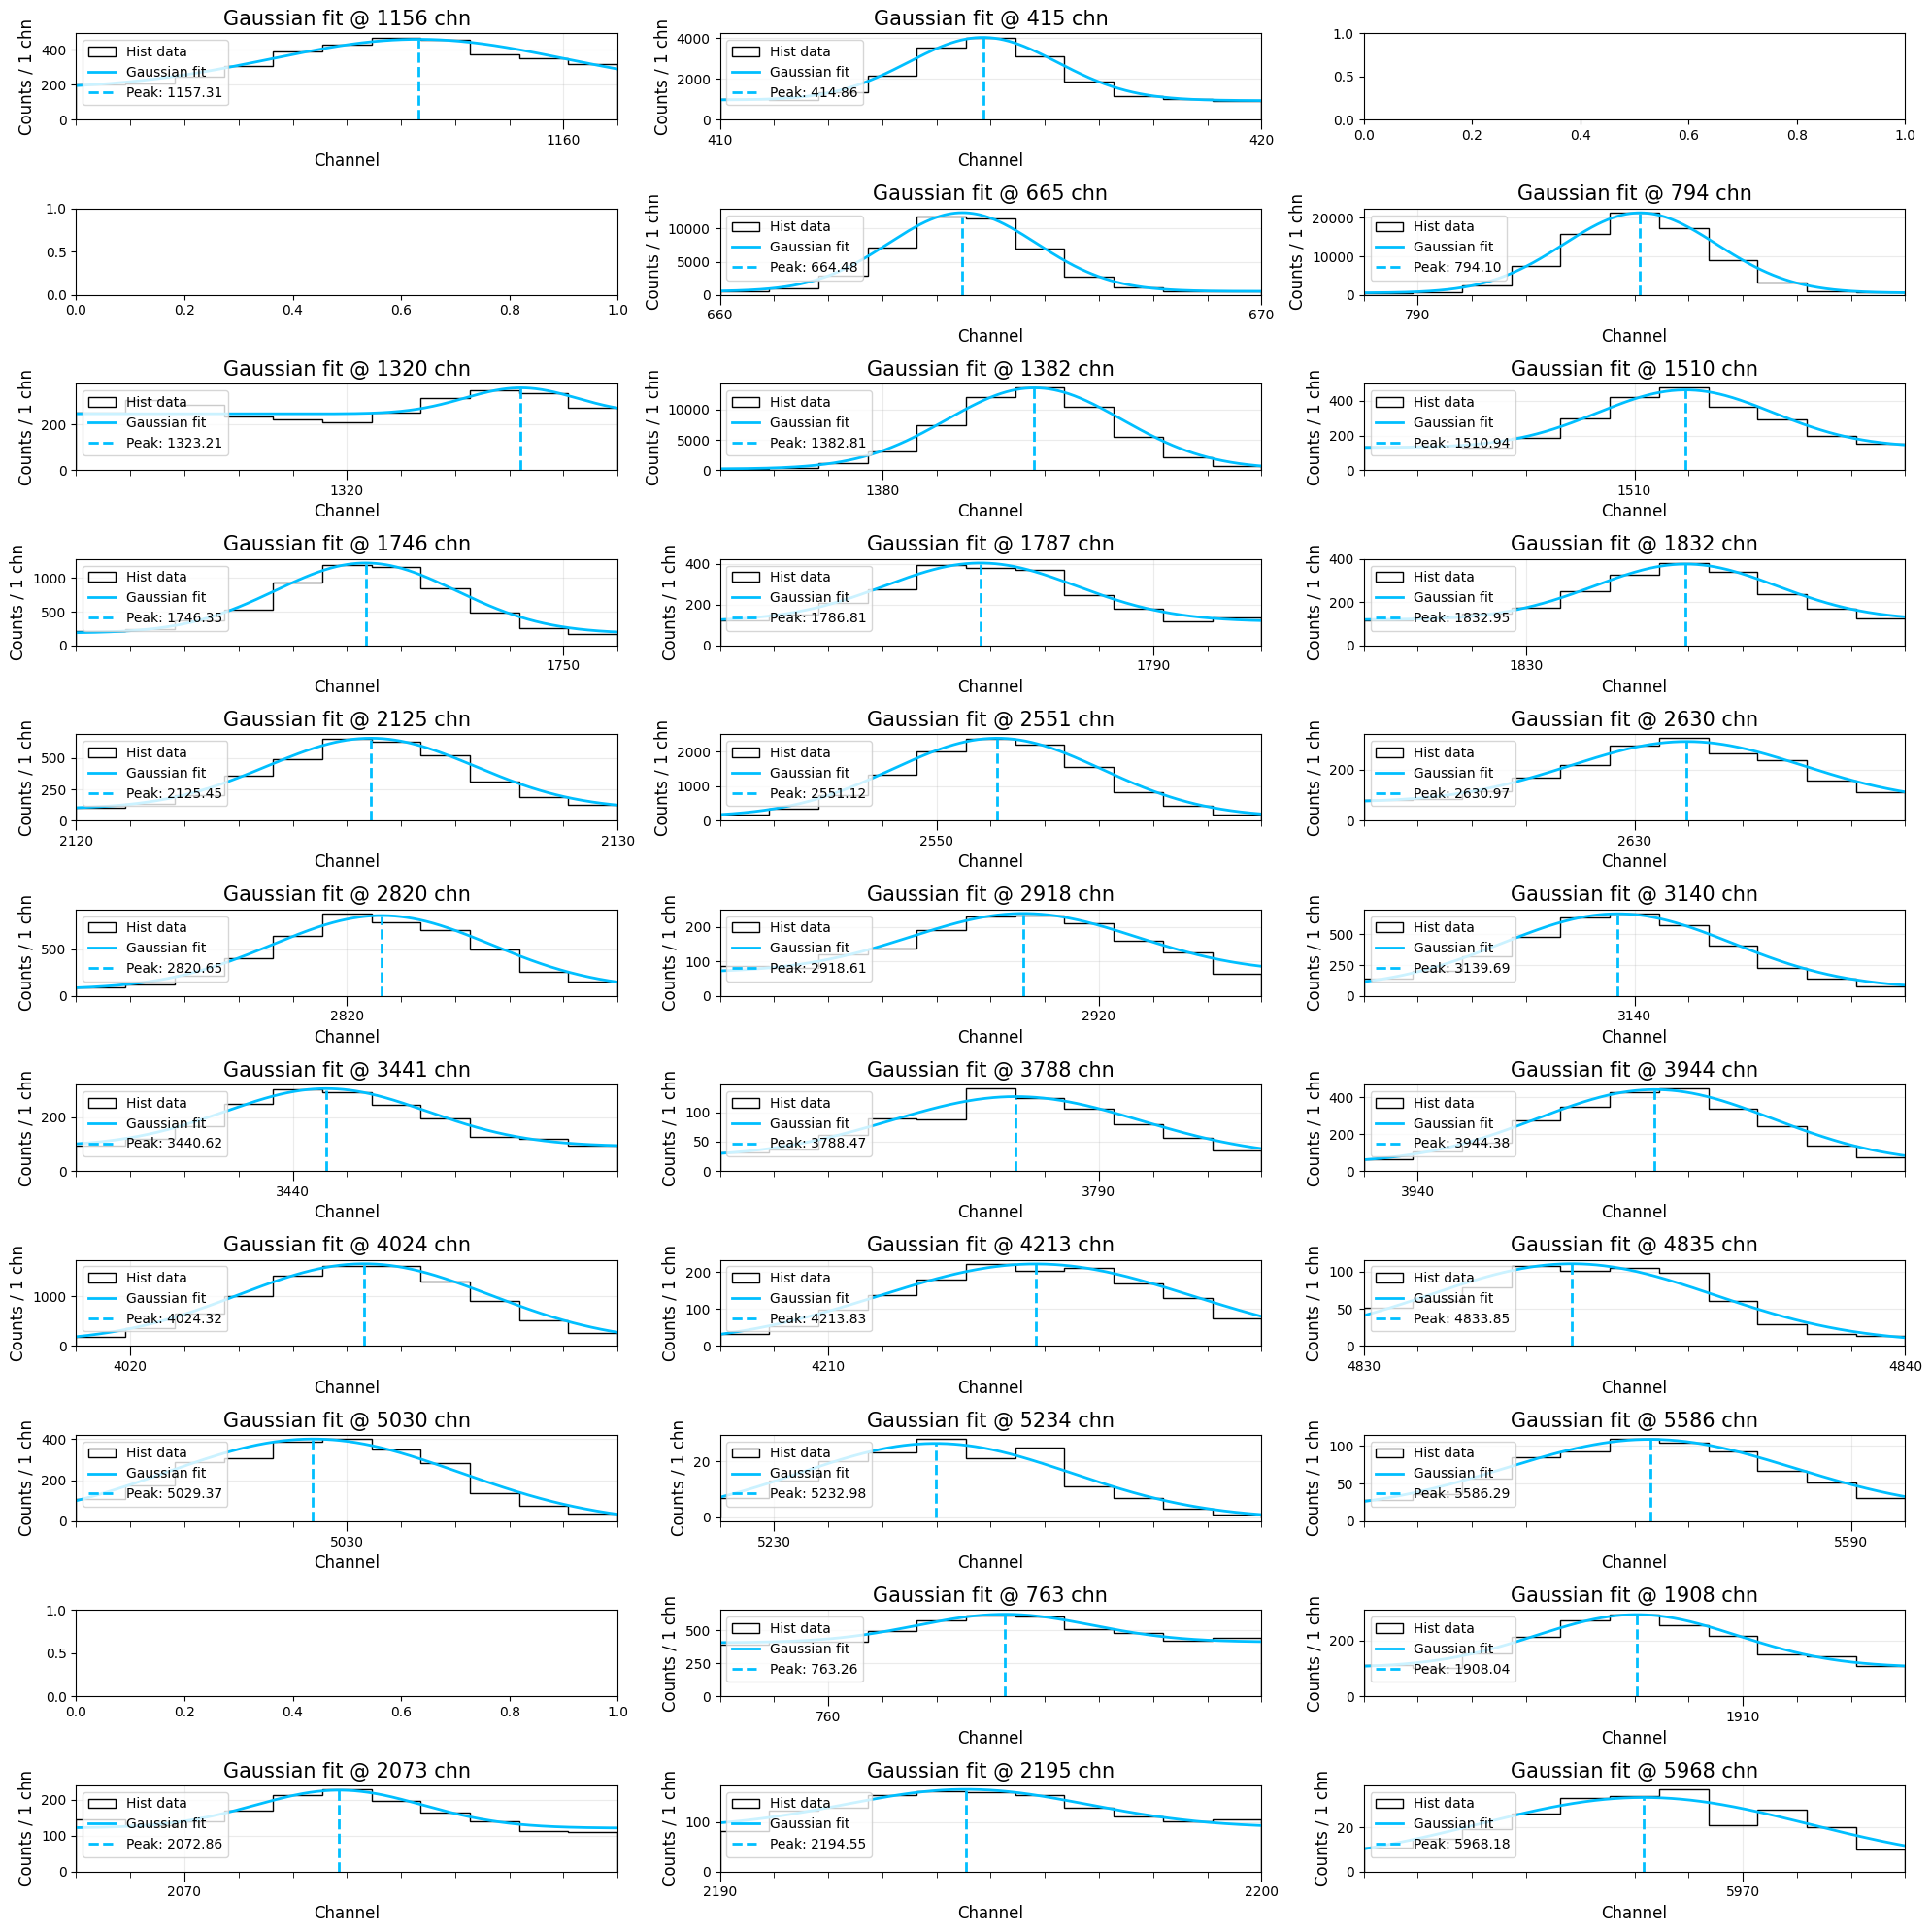

In [76]:
fig, axes = plt.subplots(11, 3, figsize=(20, 20))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_tot):
    if e < 515 or e > 560:
        #print(i)
        ax = axes[i]
        if e == 528.9:
            dx = 3
        elif e == E_chn_tot[-1]:
            dx = 5
        else:
            dx = 5
        popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        popts_U.append(popt)
        err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_tot), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [77]:
def triple_gauss_offset(x,
                        A1, mu1, sigma1,
                        A2, mu2, sigma2,
                        A3, mu3, sigma3,
                        slope, offset):
    return (offset + slope *x +
            A1 * np.exp(- (x - mu1)**2 / (2*sigma1**2)) +
            A2 * np.exp(- (x - mu2)**2 / (2*sigma2**2)) +
            A3 * np.exp(- (x - mu3)**2 / (2*sigma3**2)) )



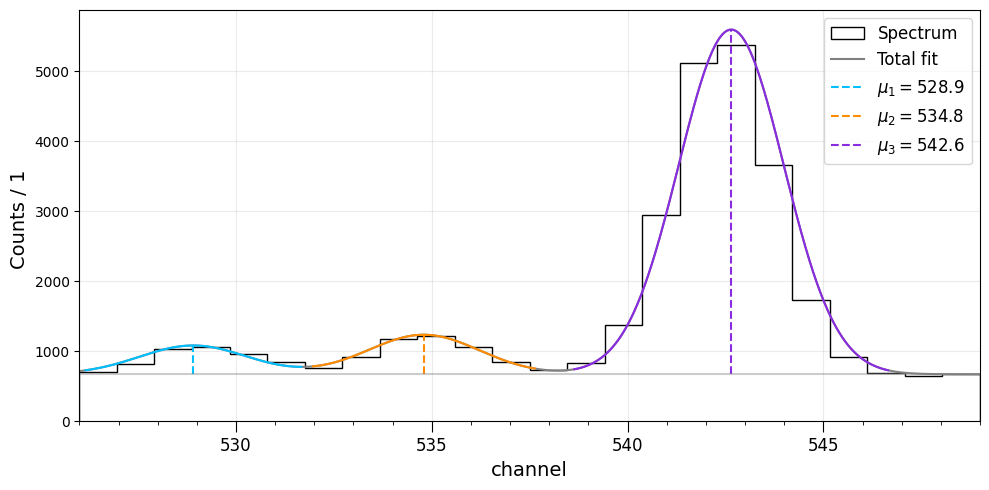

In [78]:
chn = np.arange(len(spectrum_U))

mask_2gauss = (chn > 525) & (chn < 550)

chn_2g = chn[mask_2gauss]
spectrum_2g = spectrum_U[mask_2gauss] 
plt.figure(figsize=(10, 5))

# Configura assi
dx = 5
dy = 1
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=8, labelsize=12
              )
ax.tick_params(axis='x', which='minor', length=3, labelsize=0)

# Fit tripla gaussiana + offset
p0 = [1000, 525, 0.5, 
      1000, 535, 0.5,
      2000, 543, 0.5,
      0, 100]

bounds = ([0, 500, 0,
           0, 500, 0,
           0, 500, 0,
           0, 0],
          [10000, 600,5,
           10000, 600, 5,
           10000, 600, 5,
           10000000, 100000000])

popt, pcov = curve_fit(triple_gauss_offset, chn_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Estrai parametri
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
perr = np.sqrt(np.diag(pcov))

# Istogramma
bins = np.linspace(min(chn_2g), max(chn_2g), len(chn_2g) + 1)
counts, bin_edge, _ = plt.hist(chn_2g, bins=bins, weights=spectrum_2g,
                               histtype='step', color = 'black', label='Spectrum')
db = bin_edge[1] - bin_edge[0]

# Asse x continuo per la curva
x = np.linspace(min(chn_2g), max(chn_2g), 1000)

# Curva totale
plt.plot(x, triple_gauss_offset(x, *popt), label='Total fit', color = 'grey',linewidth=1.5)

# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')
plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')



plt.hlines(offset, min(chn_2g), max(chn_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(chn_2g), max(chn_2g))
plt.xlabel('channel', size = 14)
plt.ylabel(f'Counts / {db:.0f} ', size = 14)
#plt.ylim(0, 200000)
plt.grid(alpha=0.25)
plt.legend(fontsize = 12)
plt.tight_layout()

plt.savefig("new image/ 235-245_chn_peak", dpi=300, bbox_inches='tight')

In [79]:
popt

array([4.11132646e+02, 5.28905604e+02, 1.37956236e+00, 5.64474185e+02,
       5.34794783e+02, 1.42227282e+00, 4.92146011e+03, 5.42646257e+02,
       1.34243710e+00, 4.86513427e-08, 6.73727546e+02])

In [80]:
perr

array([5.08478288e+01, 1.23426120e-01, 2.05264967e-01, 4.13264267e+01,
       8.31266150e-02, 1.14339142e-01, 3.16545051e+01, 9.43688871e-03,
       1.13643146e-02, 2.85792368e+00, 1.55790771e+03])

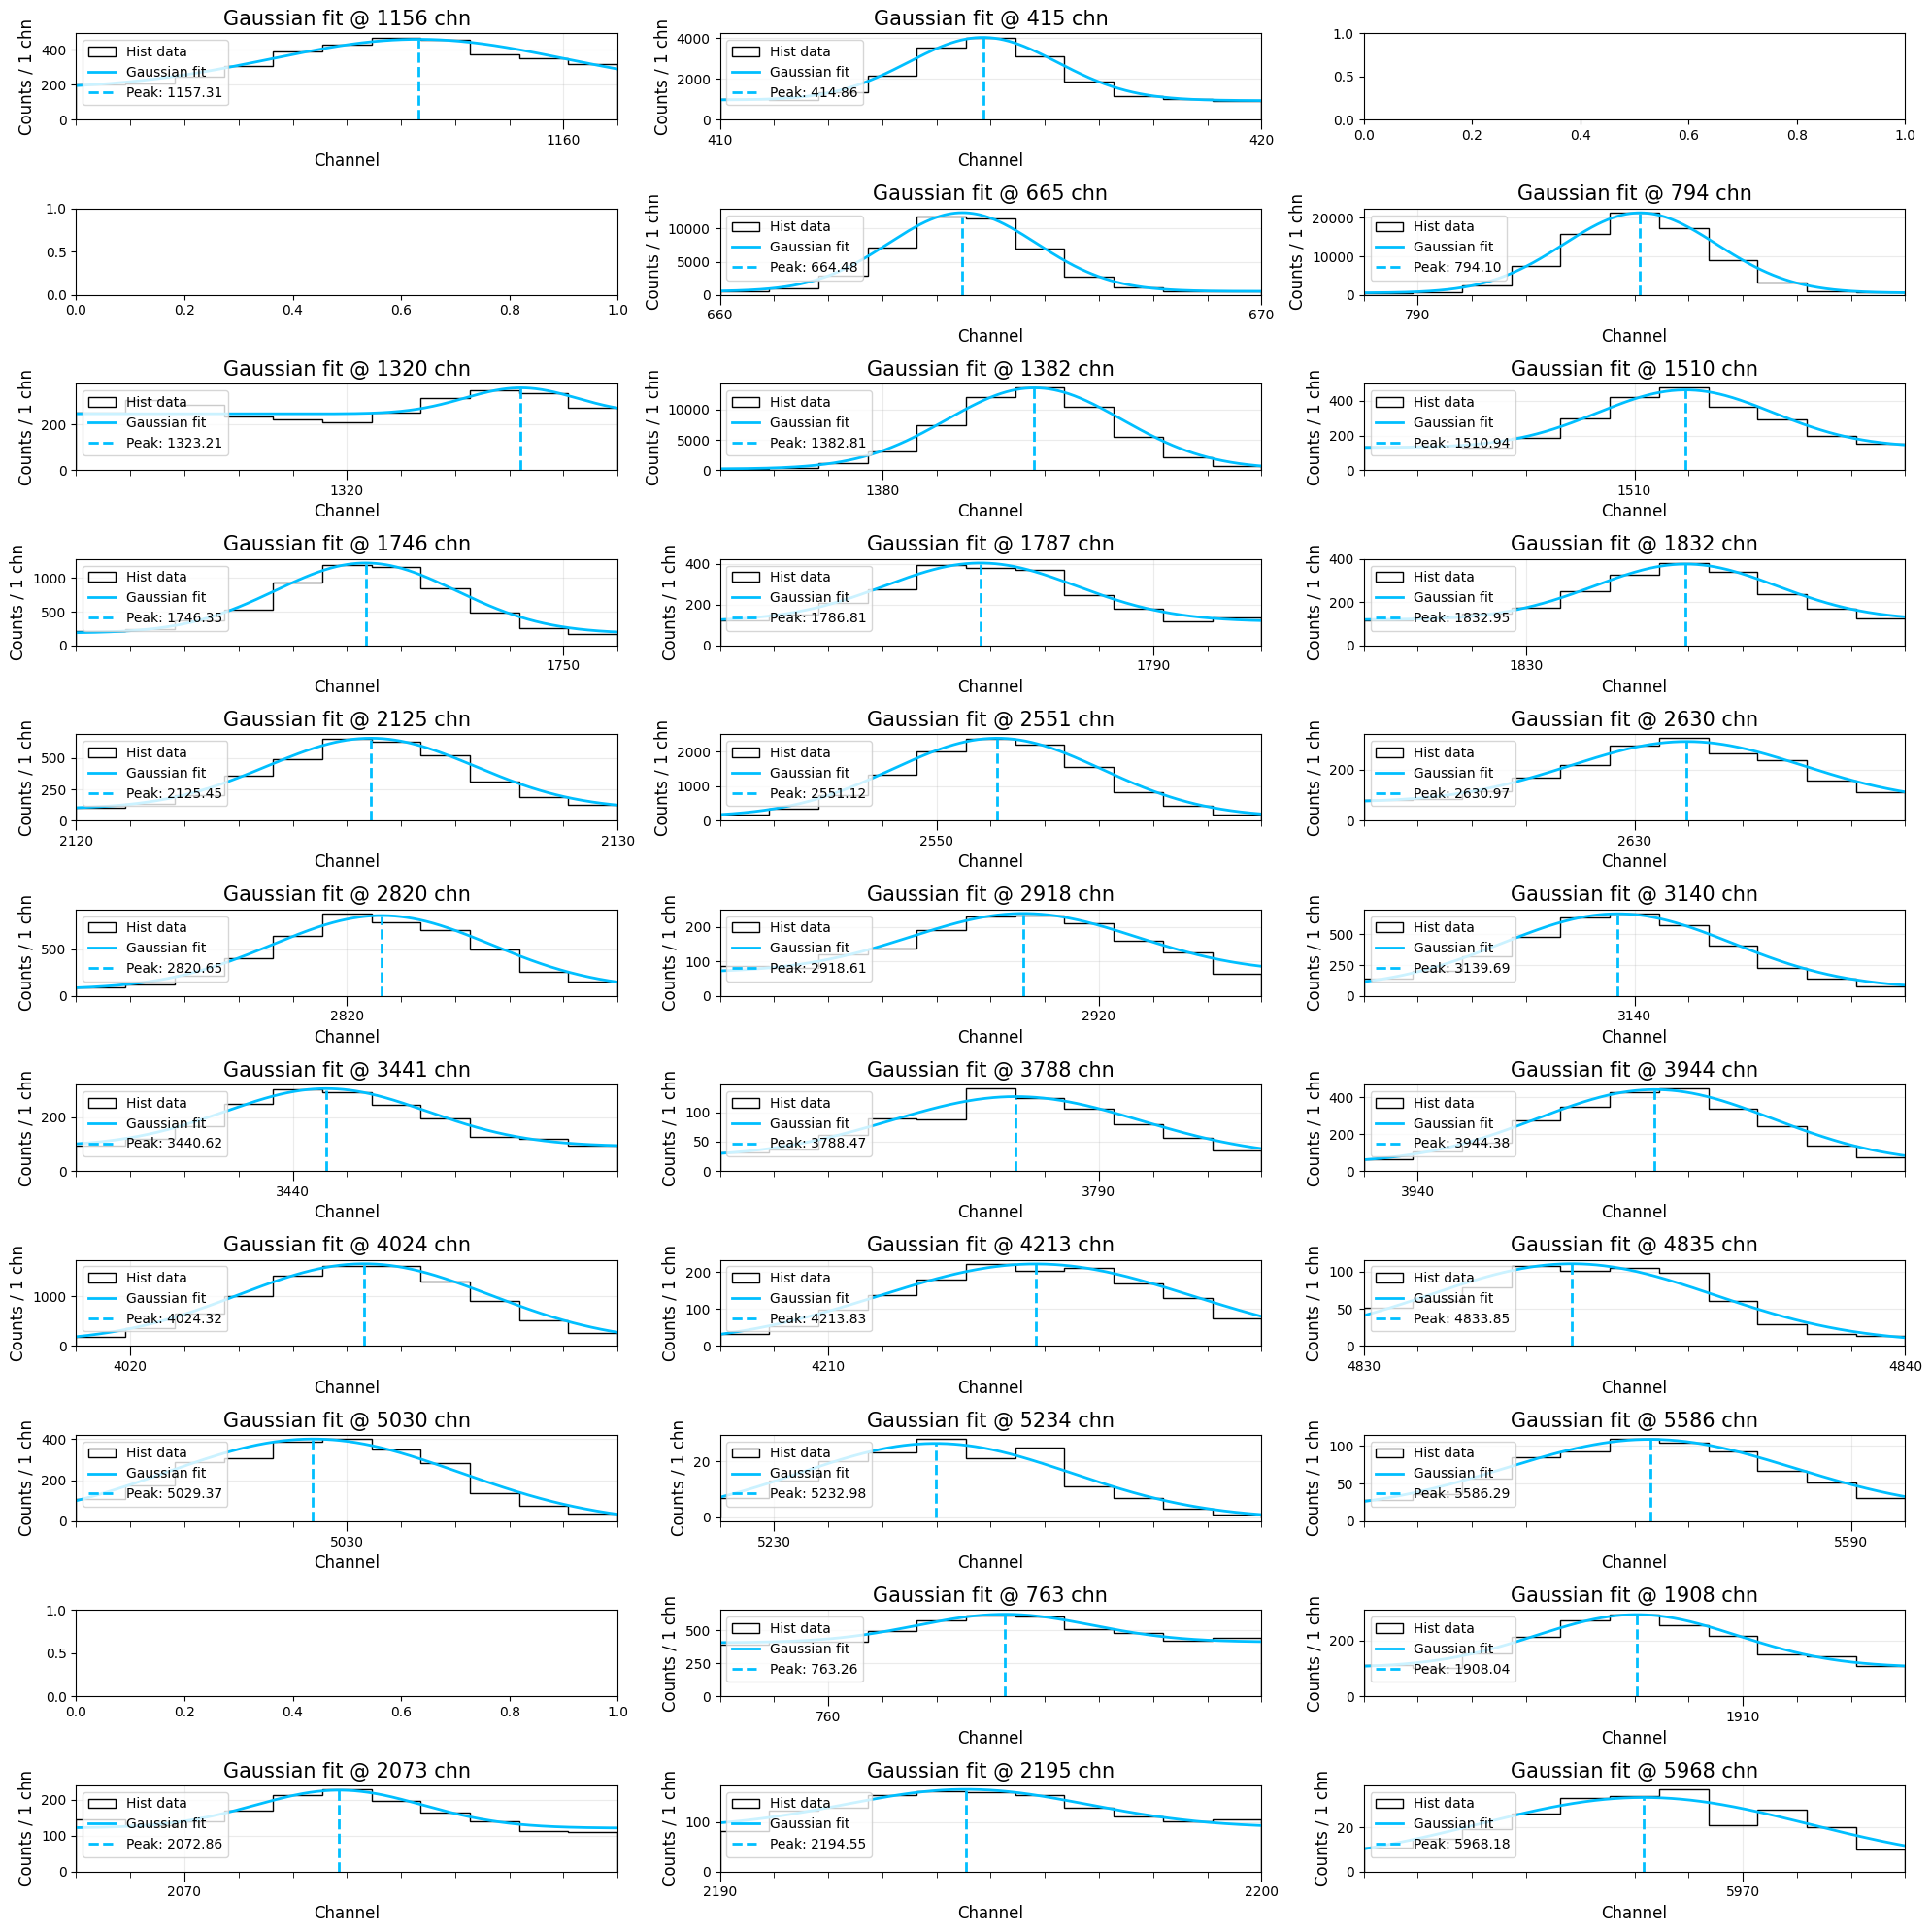

Valori mu finali: [1157.31275833  414.85897102  528.90560402  534.79478342  664.48015136
  794.10442021 1323.21120723 1382.80787539 1510.94236541 1746.34893574
 1786.81237417 1832.94792658 2125.44661236 2551.12089646 2630.96508093
 2820.64528666 2918.60768606 3139.68690692 3440.61834653 3788.4651888
 3944.37521547 4024.32105243 4213.83275452 4833.84695122 5029.37346247
 5232.98019063 5586.28887602  542.64625687  763.25830199 1908.03922361
 2072.85932928 2194.54769699 5968.1752783 ]
Errori mu finali: [0.45689597 0.01875721 0.12342612 0.08312661 0.01116716 0.00737971
 0.40352333 0.00825641 0.09809569 0.07975812 0.12173537 0.0725441
 0.05479419 0.02944827 0.12767473 0.08271676 0.23448695 0.08045811
 0.09949803 0.25893848 0.08654796 0.03582149 0.21849968 0.50957562
 0.25644943 0.36800564 0.14648629 0.00943689 0.1715701  0.15452833
 0.18440646 0.38226965 0.66714971]


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assicurati che triple_gauss_offset, fit_func, chn_2g, spectrum_2g, spectrum_U, E_chn_tot siano definiti

fig, axes = plt.subplots(11, 3, figsize=(20, 20))
axes = axes.flatten()

mu_U = []
err_U = []

# Fit triplo centrale
p0 = [1000, 525, 0.5, 
      1000, 535, 0.5,
      2000, 543, 0.5,
      0, 100]

bounds = ([0, 500, 0,
           0, 500, 0,
           0, 500, 0,
           0, 0],
          [10000, 600,5,
           10000, 600, 5,
           10000, 600, 5,
           10000000, 100000000])

popt, pcov = curve_fit(triple_gauss_offset, chn_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))
mu_vals = [popt[1], popt[4], popt[7]]
mu_errs = [perr[1], perr[4], perr[7]]
#mu_vals = [popt[1],popt[7]]
#mu_errs = [perr[1],perr[7]]
mu_err_pairs = sorted(zip(mu_vals, mu_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs = zip(*mu_err_pairs)

# Plot dei picchi
for i, e in enumerate(E_chn_tot):
    ax = axes[i]
    if 525 <= e <= 555:
        peaks_in_range = [x for x in E_chn_tot if 525 <= x <= 555]
        idx_in_range = peaks_in_range.index(e)
        mu_U.append(sorted_mu_vals[idx_in_range])
        err_U.append(sorted_mu_errs[idx_in_range])
    else:
        dx = 2 if e == 535.2102857142858 else 5
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        mu_U.append(popt_single[1])
        err_U.append(err_single[1])

# Rimuove **tutti** gli assi rimasti non usati (compresi in mezzo)
for ax in axes[len(E_chn_tot):]:
    ax.remove()

# Ridisegna layout
plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U = np.array(mu_U)
err_U = np.array(err_U)

print("Valori mu finali:", mu_U)
print("Errori mu finali:", err_U)



 a: 0.437, on b: 4.53
Uncertainty on a: 0.000148, on b: 0.44


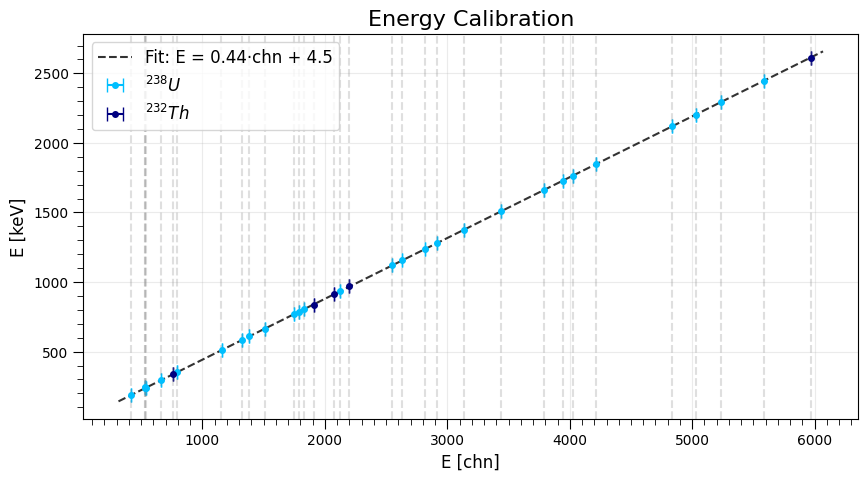

In [82]:
mu_chn = mu_U
mu_chn_err = err_U
plt.figure(figsize=(10, 5))




dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero







plt.errorbar( mu_chn[:-5],E_kev_tot[:-5], xerr=mu_chn_err[:-5], fmt='o', color = 'deepskyblue', markersize = 4, capsize=5, label=r'$^{238}U$')
plt.errorbar( mu_chn[-5:],E_kev_tot[-5:], xerr=mu_chn_err[-5:], fmt='o', color = 'navy',markersize = 4,  capsize=5, label=r'$^{232}Th$')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_tot, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f" a: {popt[0]:.3f}, on b: {popt[1]:.2f}")
print(f"Uncertainty on a: {perr_U[0]:.6f}, on b: {perr_U[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for chn in E_chn_tot:
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.25)
plt.legend(fontsize = 12, loc = 'upper left' )
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/E_ene_cal_sample", dpi=300, bbox_inches='tight')

In [83]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b
#b_prime = 6
#energies = a * channels + b_prime

In [84]:
print('b', b)
print('b bkg', b_bkg)
print('a', perr_U[0])
print('a bkg', a_bkg)

b 4.532351599600002
b bkg 4.682977688622721
a 0.00014796849233460722
a bkg 0.43738294846886144


In [85]:
perr

array([5.08478288e+01, 1.23426120e-01, 2.05264967e-01, 4.13264267e+01,
       8.31266150e-02, 1.14339142e-01, 3.16545051e+01, 9.43688871e-03,
       1.13643146e-02, 2.85792368e+00, 1.55790771e+03])

[4.19262282e+02 2.35834354e+02 6.56143628e-01 5.80528774e+02
 2.38432238e+02 6.38109915e-01 4.93449194e+03 2.41857345e+02
 5.90125255e-01 4.72808842e-21 6.55546011e+02]


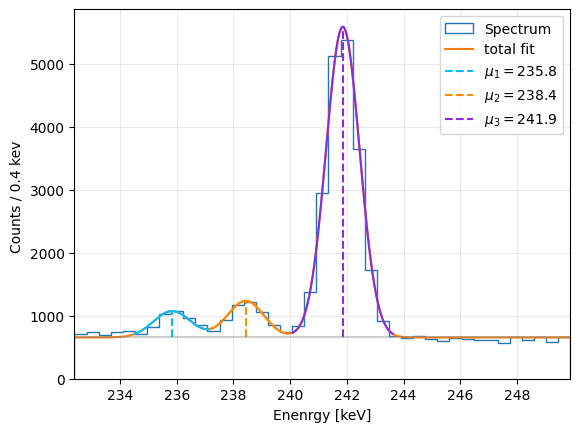

In [86]:
mask_new = (energies > 232) & (energies < 250)
ene_2g = energies[mask_new]
spectrum_2g = spectrum_U[mask_new]
bins =  np.linspace(min(ene_2g), max(ene_2g), len(ene_2g) +1 )
counts, bin_edge, _ = plt.hist(ene_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 236, 0.5, 
      1000, 238, 0.5,
      2000, 242, 0.5,
      0, 100]

bounds = ([0, 0.95*236, 0,
           0, 0.95*238, 0,
           0, 0.95*242, 0,
          0,  0],
          [10000, 1.05*236, 1,
           10000, 1.05*238, 1,
           10000, 1.1*242, 1,
           100, 1000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
x  = np.linspace(min(ene_2g), max(ene_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')

plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')


plt.hlines(offset, min(ene_2g), max(ene_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(ene_2g), max(ene_2g))
plt.grid(alpha = 0.25)
plt.xlabel('Enenrgy [keV]')
plt.ylabel(f'Counts / {db:.1f} kev ')
plt.legend()
print(popt)

In [87]:
perr

array([3.90542350e+01, 6.84099690e-02, 7.74754267e-02, 3.90069413e+01,
       4.84215497e-02, 5.22757348e-02, 3.88356746e+01, 5.25814913e-03,
       5.54831380e-03, 1.79283754e+00, 4.36738515e+02])

In [88]:
1.13/7.43

0.15208613728129206

In [89]:
5.69971131e+02/4.92542446e+03

0.11572020556376576

[4.19262282e+02 2.35834354e+02 6.56143628e-01 5.80528774e+02
 2.38432238e+02 6.38109915e-01 4.93449194e+03 2.41857345e+02
 5.90125255e-01 4.72808842e-21 6.55546011e+02]
235.83435443002685 238.43223757030776 241.85734527314457
sigma errs [np.float64(0.07747542670805765), np.float64(0.05227573476228806), np.float64(0.005548313796571658)]


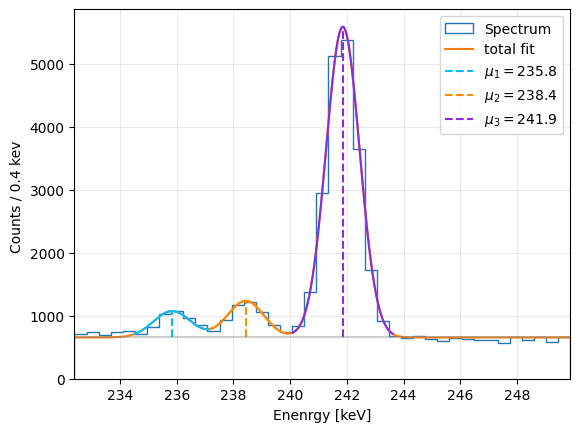

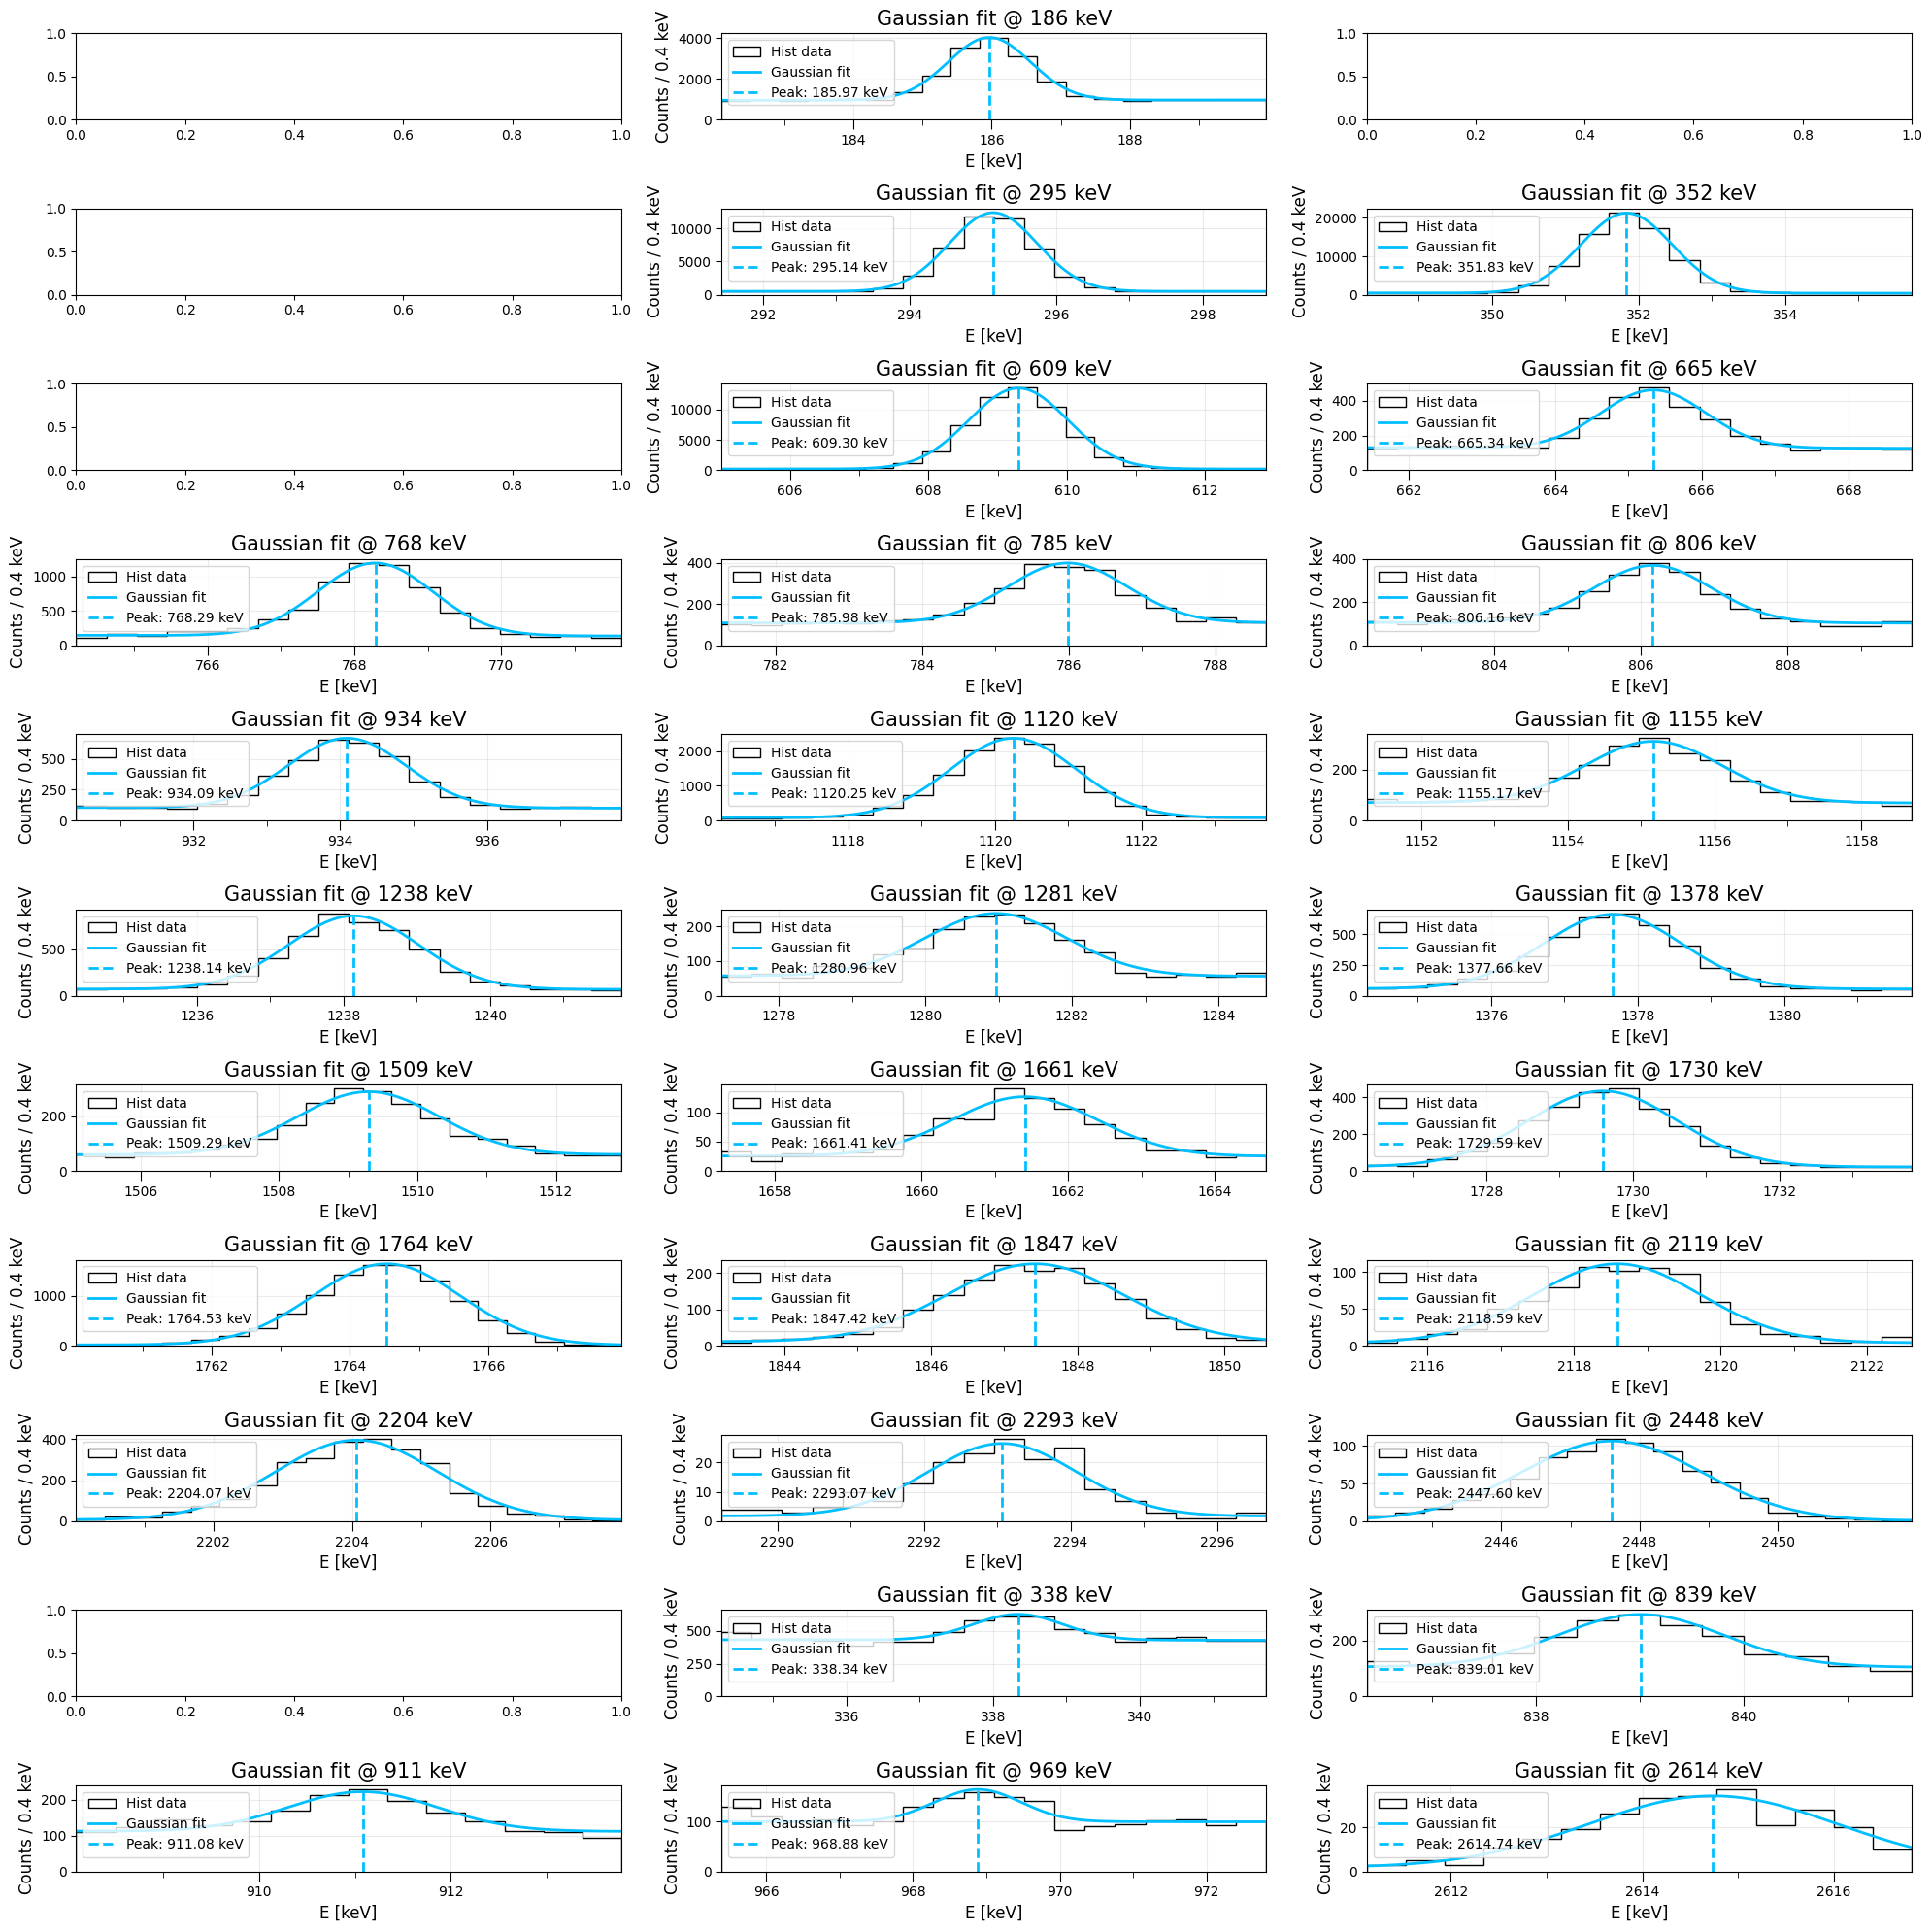

In [90]:
mu_U_kev = []
err_mu_U_kev = []
sigma_U_kev = []
err_sigma_U_kev = []

# Fit triplo
mask_new = (energies > 232) & (energies < 250)
ene_2g = energies[mask_new]
spectrum_2g = spectrum_U[mask_new]
bins =  np.linspace(min(ene_2g), max(ene_2g), len(ene_2g) +1 )
counts, bin_edge, _ = plt.hist(ene_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 236, 0.5, 
      1000, 238, 0.5,
      2000, 242, 0.5,
      0, 100]

bounds = ([0, 0.95*236, 0,
           0, 0.95*238, 0,
           0, 0.95*242, 0,
          0,  0],
          [10000, 1.05*236, 1,
           10000, 1.05*238, 1,
           10000, 1.1*242, 1,
           100, 1000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
dA1, dmu1, dsigma1, dA2, dmu2, dsigma2, dA3, dmu3, dsigma3, dslope, doffset = perr
x  = np.linspace(min(ene_2g), max(ene_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')

plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')


plt.hlines(offset, min(ene_2g), max(ene_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(ene_2g), max(ene_2g))
plt.grid(alpha = 0.25)
plt.xlabel('Enenrgy [keV]')
plt.ylabel(f'Counts / {db:.1f} kev ')
plt.legend()
print(popt)

# estrai e ordina mu e sigma con errori
mu_vals = [mu1,mu2, mu3]
print(mu1,mu2, mu3)
sigma_vals = [sigma1, sigma2, sigma3]
mu_errs =  [dmu1,dmu2, dmu3]
sigma_errs = [dsigma1, dsigma2, dsigma3]
#mu_vals = [popt[1], popt[7]]
#sigma_vals = [popt[2], popt[8]]
#mu_errs = [perr[1],  perr[7]]
#sigma_errs = [perr[2], perr[8]]
print('sigma errs', sigma_errs)
mu_err_pairs = sorted(zip(mu_vals, mu_errs, sigma_vals, sigma_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs, sorted_sigma_vals, sorted_sigma_errs = zip(*mu_err_pairs)
fig, axes = plt.subplots(11, 3, figsize=(20, 20))  # 27 subplot
axes = axes.flatten()
# ciclo sui picchi
for i, e in enumerate(E_kev_tot):
    ax = axes[i]
    
    if 220 <= e <= 250:
        peaks_in_range = [x for x in E_kev_tot if 220 <= x <= 250]
        idx_in_range = peaks_in_range.index(e)
        
        mu_U_kev.append(sorted_mu_vals[idx_in_range])
        err_mu_U_kev.append(sorted_mu_errs[idx_in_range])
        
        sigma_U_kev.append(sorted_sigma_vals[idx_in_range])
        err_sigma_U_kev.append(sorted_sigma_errs[idx_in_range])
        
    else:
        if e == E_kev_tot[-1]:
            dx = 3
        elif e ==  583.5:
            dx = 4
        elif e ==  338.5:
            dx = 4
        elif e == 837.8:
            e = e+1
            dx = 3
        elif e ==911.204:
            dx = 3
        elif e ==580.13:
            continue
        elif e ==511:
            continue
        else:
            dx = 4
            #print('mao')
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, kev=True, energies=energies, ax=ax)
        
        mu_U_kev.append(popt_single[1])
        err_mu_U_kev.append(err_single[1])
        sigma_U_kev.append(popt_single[2])        # sigma
        err_sigma_U_kev.append(err_single[2])     # errore sigma


plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U_kev = np.array(mu_U_kev)
err_mu_U_kev = np.array(err_mu_U_kev)
sigma_U_kev = np.array(sigma_U_kev)
err_sigma_U_kev = np.array(err_sigma_U_kev)



In [91]:
E_kev_tot

array([ 511.   ,  185.712,  236.   ,  242.   ,  295.224,  351.932,
        580.13 ,  609.312,  665.45 ,  768.356,  785.356,  806.174,
        934.061, 1120.287, 1155.19 , 1238.11 , 1280.96 , 1377.669,
       1509.228, 1661.28 , 1729.595, 1764.494, 1847.42 , 2118.55 ,
       2204.   , 2293.4  , 2447.86 ,  238.632,  338.32 ,  837.8  ,
        911.204,  968.971, 2614.   ])

In [92]:

def reorder_arr1(E_kev_tot, mu_kev):
    reordered = []
    used_indices = set()
    for val in mu_kev:
        # Trova indice in arr1 con valore più vicino a val e non ancora usato
        diffs = np.abs(E_kev_tot - val)
        for idx in np.argsort(diffs):
            if idx not in used_indices:
                used_indices.add(idx)
                reordered.append(E_kev_tot[idx])
                break
    return np.array(reordered)

In [93]:
mu_kev = reorder_arr1(E_kev_tot, mu_kev)

In [94]:
val1 = 238.632
val2 = 242

# Trova gli indici corrispondenti
i = np.where(mu_kev == val1)[0][0]
j = np.where(mu_kev == val2)[0][0]

# Scambia i valori
mu_kev[i], mu_kev[j] = mu_kev[j], mu_kev[i]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
E_kev_tot

In [ ]:
mu_kev

In [ ]:

plt.figure(figsize=(12, 5))

dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma dello spettro
chn = np.arange(len(spectrum_U))
bins = np.linspace(min(energies), max(energies), len(energies)+1)
counts, bin_edge, _ = plt.hist(
    energies,
    bins=bins,
    weights=spectrum_U,
    histtype='step',
    label='Spectrum'
)

db = bin_edge[1] - bin_edge[0]

# Flag per visualizzare etichette in legenda solo una volta
plotted_U = False
plotted_Th = False

# Picchi 238U
for ch in mu_U_kev[:-6]:
    ch_idx = np.searchsorted(bin_edge, ch) 
    if 0 <= ch_idx < len(counts):
        y = counts[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='deepskyblue', marker='x', s=80,
                    label=r'$^{238}$U' if not plotted_U else "")
        plotted_U = True

# Picchi 232Th
for ch in mu_U_kev[-6:]:
    ch_idx = np.searchsorted(bin_edge, ch) - 1
    if 0 <= ch_idx < len(counts):
        y = counts[ch_idx]
        
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='navy', marker='x', s=80,
                    label=r'$^{232}$Th' if not plotted_Th else "")
        plotted_Th = True

ch_ann = 511
ch_idx = np.searchsorted(bin_edge, ch_ann) - 1
if 0 <= ch_idx < len(counts):
    y = counts[ch_idx]
    plt.axvline(x=ch_ann, color='grey', linestyle='--', alpha=0.5)
    plt.scatter(ch_ann, y, color='black', marker='x', s=80, label='Annihilation')


# Labels e stile grafico
plt.xlabel('Energy (keV)', size=14)
plt.ylabel(f'Counts / {db:.1f} keV', size=14)
plt.title('Sample Spectrum')
plt.xlim(0, 3000)
plt.ylim(1, max(counts)*3)


plt.vlines(2615-511, 1, 500000, color = 'grey', alpha = 0.25, lw = 4 )
plt.vlines(2615-511-511, 1, 500000, color = 'grey', alpha = 0.25, lw = 4 )
plt.text(2614-511, 1e3, r"$^{208}Tl$ SEP",rotation=90, va='bottom', ha='center', size=10, color='black')
plt.text(2614-511-511, 1e3, r"$^{208}Tl$ DEP",rotation=90, va='bottom', ha='center', size=10, color='black')

plt.vlines(185, 1, 500, color ='red')
plt.vlines(235.97, 1, 500, color ='red')
plt.vlines(270, 1, 500, color ='red')
plt.vlines(351, 1, 500, color ='red')

plt.yscale('log')
plt.grid(alpha=0.24)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("new image/238U_kev", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
FWHM_errindex_anomalous = np.argmax(FWHM_err)
print("Indice del valore anomalo:", FWHM_errindex_anomalous)
print(mu_kev[FWHM_errindex_anomalous])
print(FWHM_err[FWHM_errindex_anomalous])
print(sigma[FWHM_errindex_anomalous])
print(sigma_err_kev[FWHM_errindex_anomalous])


In [ ]:
mu_U_kev

In [ ]:


sigma=sigma_U_kev
sigma_err_kev =err_sigma_U_kev
mu_kev=mu_U_kev
mu_kev_err=err_mu_U_kev
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err


# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
# Fino al -5: Uranio
plt.errorbar(mu_kev[:-6], FWHM[:-6] * 100,
             
             #yerr =  0.1,
             yerr=FWHM_err[:-6]* 100,
             fmt='o',
             color='deepskyblue',
             markersize=3,
             label=r'$^{238}$U')

# Ultimi 5: Torio
plt.errorbar(mu_kev[-6:], FWHM[-6:] * 100,
             
             yerr=FWHM_err[-6:]* 100,
             fmt='o',
             color='navy',
             markersize=3,
             label=r'$^{232}$Th')

upper_curve = fhwm_func(E_fit, popt[0] + 2*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 2*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("new image/FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

# Subtracted Spectrum

In [ ]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b

In [ ]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u

In [ ]:
Utime = 625 #s
bkg_time = 76752 #s

conversion = Utime/bkg_time

In [ ]:
spectrum_bkg_norm = spectrum_bkg*conversion

In [ ]:
spectrum_fin = spectrum_U-spectrum_bkg_norm

In [ ]:
len(spectrum_fin)

In [ ]:
chn = np.linspace(0, len(spectrum_fin), len(spectrum_fin))
energies = chn*a + b

In [ ]:
plt.plot(energies, spectrum_fin)
plt.yscale('log')
plt.ylim(1, 1e6)

## X-ray peaks below 240 keV

In [ ]:
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}


In [ ]:
import matplotlib.pyplot as plt
from pastamarkers import pasta, salsa


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Maschera per lo zoom nello spettro (50 keV < E < 150 keV)
mask = (energies > 60) & (energies < 110)
energies_X = energies[mask]
spec_X = spectrum_fin[mask]

# Trova picchi sopra soglia
peaks, properties = find_peaks(spec_X, height=3.1e4)

# Picchi noti dell’Uranio (serie L)
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}

# Nuovi picchi identificati
extra_peaks = {
    63.290 : r'$^{234}$Th',
     84.373 : r'$^{228}$Th',
    92.5: r'$^{234}$Th',
    99.0: r'$^{228}$Ac',
}

tolerance = 1.0

# Flag per mostrare label una sola volta
plotted_known = False
plotted_unknown = False
plotted_extra = False

# Plot dello spettro
plt.figure(figsize=(12, 5))

dx = 5
dy = 1
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




bins = np.linspace(min(energies_X), max(energies_X), len(energies_X)+1)
hist, bins_edge, _ = plt.hist(energies_X, bins = bins, weights = spec_X, histtype='step', label = 'Spectrum')
db = 0.5*(bins_edge[1]-bins_edge[0])
#plt.plot(energies_X, spec_X, linewidth=1, label='Spectrum')
plt.xlabel(f'Energy [keV]', fontsize=13)
plt.ylabel(f'Counts \ {db:.1f} keV', fontsize=13)
plt.title('Zoomed Spectrum with X-ray Peaks (60–120 keV)', fontsize=15)
plt.xlim(min(energies_X), max(energies_X))
plt.ylim(0, 14.5e4)

# Loop su tutti i picchi
for p in peaks:
    energy_p = energies_X[p]
    count_p = spec_X[p]
    print(energy_p)

    matched = False

    # Verifica se è un picco della serie L dell'Uranio
    for ref_energy, label in x_peaks_uranio.items():
        if abs(energy_p - ref_energy) < tolerance:
            matched = True
            plt.scatter(energy_p, count_p, color='black', marker='x', s=100,
                        label='Known X-ray peaks' if not plotted_known else "")
            plt.text(energy_p, count_p + 4500, f'{label}',
                     fontsize=13, rotation=270, ha='center', va='bottom')
            plotted_known = True
            break
    

    # Verifica se è un picco extra noto (Th o Ac)
    if not matched:
        for ref_energy, label in extra_peaks.items():
            if abs(energy_p - ref_energy) < tolerance:
                matched = True
                plt.scatter(energy_p, count_p, color='darkorange', marker='D', s=80,
                            label=r'Other known $\gamma$-peaks' if not plotted_extra else "")
                plt.text(energy_p, count_p + 4500, f'{label}',
                         fontsize=13, rotation=270, ha='center', va='bottom')
                plotted_extra = True
                break

    # Se non è noto → unknown
    if not matched:
        plt.scatter(energy_p, count_p, color='deepskyblue', marker='x', s=60,
                    label='Unknown peaks' if not plotted_unknown else "")
        plotted_unknown = True

manual_energy = 64
# Trova l'indice più vicino
idx_closest = (np.abs(energies_X - manual_energy)).argmin()
manual_count = spec_X[idx_closest]

# Plot del punto
plt.scatter(manual_energy, manual_count, color='darkorange', marker='D', s=80,
            label='Other known peaks' if not plotted_extra else "")
plt.text(manual_energy, manual_count + 4500, r'$^{234}$Th',
         fontsize=13, rotation=270, ha='center', va='bottom')


# Linee verticali tratteggiate per i picchi della serie L
for ref_energy, label in x_peaks_uranio.items():
    plt.axvline(ref_energy+0.7, color='grey', linestyle='--', alpha=0.5)

plt.grid(alpha=0.15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("new image/ x-rays", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# picco a 90 -- picchi gamma del th
#picco a 99 kev è il picco gamma dell'>Ac dalla catena del thorio

## Continue activity

In [ ]:
# Parametri per tacche su asse x
dx = 500  # numeri ogni 500 keV
dy = 100  # tacche ogni 100 keV

E_fit = np.linspace(50, 3000, 1000)

plt.figure(figsize=(8, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

plt.plot(E_fit, fhwm_func(E_fit,a_res_bkg, b_res_bkg)*100, lw = 1, color = 'deepskyblue', label=r'Background (close shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_open_res, b_open_res)*100, lw = 1, color = 'orangered', label=r'Background (open shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_res_U, b_res_U)*100, lw = 1, color = 'green',  label = 'Source')
#plt.plot(E_fit, fhwm_func(E_fit,a_res, b_res)*100, label=r'Source - Background')


#curva source
upper_curve = fhwm_func(E_fit,a_res_U + perr_U_res[0],b_res_U) * 100
lower_curve = fhwm_func(E_fit, a_res_U - perr_U_res[0], b_res_U) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='green', alpha=0.15, label = r'$\pm \sigma$')


#baclgroung
upper_curve = fhwm_func(E_fit, a_res_bkg + perr_back_res[0], b_res_bkg) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg - perr_back_res[0],b_res_bkg) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='deepskyblue', alpha=0.15, label = r'$\pm \sigma$')

#background open
upper_curve = fhwm_func(E_fit,a_open_res + perr_open_res[0], b_open_res)*100
lower_curve = fhwm_func(E_fit,a_open_res - perr_open_res[0], b_open_res)*100
plt.fill_between(E_fit, lower_curve, upper_curve, color='orangered', alpha=0.35, label = r'$\pm \sigma$')


plt.yscale('log')

plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.savefig("new image/ comparison_res", dpi=300, bbox_inches='tight')
plt.xlim(0,3000)

### !!!

Manually creating a bettere enrgy resolution ---> cancelig the widers tails

[Aggiungi]

## Average activity Estimation

In [ ]:

E_214Pb = 295.224
I_214Pb = 0.193

E_214Pb = 241.997
I_214Pb = 0.0743


E_214Pb = 351.932
I_214Pb = 0.376



dx = 3
popt_214, err_214, _ = fit_func_sottratto( spectrum_U, spectrum_bkg_norm, E_214Pb, dx=dx, kev = True, energies= energies)

A_eff = popt_214[0]/(I_214Pb * t_real_u)

# the maximum efficiency is around 5%
eff_max = 0.045

A_max = A_eff/(eff_max)
dA_max = err_214[0]/(I_214Pb * t_real_u)

In [ ]:
A_max

In [ ]:
dA_max

# Average activity estimation

In [ ]:
mask = (energies_open > 60) & (energies_open < 3000)

spectr_3Mev = spectrum_U[mask]
cps_total = np.sum(spectr_3Mev)/(t_real_u)

print(f'count rate totale {cps_total:.0f} cps')

In [ ]:
perr[4]

In [ ]:
hannels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))  # 1 riga, 3 colonne
E_kev = np.sort([609, 583.12]) #kev
popt_kev = []
popt_kev_err = []
N_kev = []
N_kev_err = []
dofs = []
for i, e in enumerate(E_kev):
    if e == E_kev[0]:
        dx = 2
    else:
        dx=4
    popt, err, dof = fit_func( spectrum_U, e, dx = dx, kev = True, energies = energies, ax=axes[i])
    popt_kev.append(popt[1])
    popt_kev_err.append(err[1])
    N_kev.append(popt[0])
    N_kev_err.append(err[0])
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("new image/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
popt_kev

In [ ]:
N_kev[0]

In [ ]:
frac_th = ((N_kev[0]*0.3036)/(N_kev[1]*0.461))
print(frac_th)
cps_thorium = cps_total * frac_th
cps_U = cps_total * ( 1 -frac_th)

print(f' cps totale {cps_total:.0f} cps')
print(f' cps thorium {cps_thorium:.0f} cps')
print(f' cps uranium  {cps_U:.0f} cps')

In [ ]:
def propagated_uncertainty(Ui, N1, sigma_N1, Y1, N2, sigma_N2, Y2):
    dUf_dN1 = -Ui * Y1 / (N2 * Y2)
    dUf_dN2 = Ui * N1 * Y1 / (N2**2 * Y2)
    
    sigma_Uf = np.sqrt((dUf_dN1 * sigma_N1)**2 + (dUf_dN2 * sigma_N2)**2)
    return sigma_Uf


In [ ]:
dcps_U = propagated_uncertainty(cps_total,N_kev[0],N_kev_err[0],0.3036,N_kev[1],N_kev_err[1],0.461 )

In [ ]:
# mi divio il count rate totale in 4 isotopi principali

A0 = cps_U/4
dA0= dcps_U/4
print('A0', A0)
print('dA0', dA0)

eff_max = 0.05

A_max_new = A0/(eff_max)
dA_max_new= dA0 / eff_max

print('diviso efficineza', A_max_new)
print('err efficineza', dA_max_new)

# Attività

In [ ]:
def potenza(E, a, k):
    return k * np.pow(E, -a)

In [ ]:
def linear(x,a,b):
    return -a*x + b

### Lead 214 Pb

In [ ]:
b = 5.3
energies = a * channels + b


E_214Bi = [
    609.312,
    934.061,
    1120.287,
    1238.110,
    1377.669,
    1764.494,
    2204.210
]

I_214Bi = [
    0.461,
    0.0303,
    0.151,
    0.0579,
    0.04,
    0.150,
    0.058
]



In [ ]:
E_214Bi =  [2204.21,
            2118.55,
            1847.42,
            1764.49,
            1729.595,
            1377.669]
I_214Bi = [0.05,
          0.01,
          0.02,
          0.15,
          0.03,
          0.04]

In [ ]:
E_214Pb = [ 241.997,
            295.224,
            351.932]

I_214Pb = [ 0.0743,
            0.193,
            0.376]

E_Ra = [ 186.221]

I_Ra = [ 0.0359]


In [ ]:
0.02811+ 0.0277

In [ ]:
###### faccio un unico picco a 90 kev 
E_th = [63.290, 92.60]
I_th = [0.0484, 0.05581]

In [ ]:
E_tot = []
E_tot.extend(E_th)
E_tot.extend(E_Ra)
E_tot.extend(E_214Pb)
E_tot.extend(E_214Bi)
E_tot = np.array(E_tot)


In [ ]:
I_tot = []
I_tot.extend(I_th)
I_tot.extend(I_Ra)
I_tot.extend(I_214Pb)
I_tot.extend(I_214Bi)

I_tot = np.array(I_tot)

In [ ]:
len(I_tot)

In [ ]:
E_tot[6]

In [ ]:
mask_th = (energies > 91) & (energies < 105)
ene_th = energies[mask_th]
spec_th = spectrum_fin[mask_th]
bins = np.linspace(min(ene_th), max(ene_th), len(ene_th)+1)
counts, bin_edge, _ = plt.hist(ene_th, bins = bins, weights = spec_th, histtype='step' )


p0 = [40000, 93, 0.1, 
      40000, 95,  0.1, 
      80000, 99,  0.1, 
      0, 10000]

bounds = ([0,0.9*92,0,
          0,0.9*93,0,
          0,0.9*99,0,
          -1000, 0],
         [1000000,1.1*92,50,
         1000000,1.1*93,50,
         1000000,1.1*99,50,
         1000, 10000000])

popt, pcov = curve_fit(triple_gauss_offset,
                       ene_th, spec_th,
                       p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))

A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt

x  = np.linspace(min(bins), max(bins), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')

plt.xlim(min(ene_th), max(ene_th))

In [ ]:
popts_N = []
errs_N = []

popts_mu = []
errs_mu = []
popts_N.append(A1)
errs_N.append(perr[0])
popts_mu.append(mu1)
errs_mu.append(perr[1])

fig, axes = plt.subplots(5, 3, figsize=(18, 16))  # 4 righe, 2 colonne


for i, e in enumerate(E_tot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    print(e)
    if e == 92.60:
        continue

    if e == 63.290:
        continue
    elif e == 1661.28 :
        dx = 10
    else:
        dx = 10

    popt, err, _ = fit_func_sottratto(
        spectrum_U, spectrum_bkg_norm, e,
        dx=dx, kev=True, energies=energies, ax=ax
    )

    if popt is not None:
        popts_N.append(popt[0])
        errs_N.append(err[0] * 1.1)
        popts_mu.append(popt[1])
        errs_mu.append(err[1] * 1.1)




plt.tight_layout()
plt.show()


In [ ]:
# Scambiare primo e secondo elemento
popts_N[0], popts_N[1] = popts_N[1], popts_N[0]
errs_N[0], errs_N[1] = errs_N[1], errs_N[0]
popts_mu[0], popts_mu[1] = popts_mu[1], popts_mu[0]
errs_mu[0], errs_mu[1] = errs_mu[1], errs_mu[0]


In [ ]:
Y = []
sigma_Y = []
sigma_logY = []

import numpy as np

# Converti in array nel caso non lo siano
mu_kev = np.array(popts_mu)
mu_kev_err = np.array(errs_mu)
N_U = np.array(popts_N)
N_U_err = np.array(errs_N)


for i in range(len(N_U)):
    # non divido per l'efficienza
    num = N_U[i]
    sigma_num = N_U_err[i]  # deve essere definito

    #eff = get_eff_value(mu_kev[i], x_eff, eff_value)
    den = t_real_u  * I_tot[i]

    Y_i = num / den
    sigma_Y_i = sigma_num / den

    sigma_logY.append( (sigma_num)/num)
    Y.append(Y_i)
    sigma_Y.append(sigma_Y_i)

In [ ]:
y_fit = Y[2:]
mu_fit = mu_kev[2:]
sigma_err = sigma_logY[2:]

x = np.linspace(min(mu_kev)-150, max(mu_kev)+150, 10000)

plt.figure(figsize=(8,5))

bounds = ([0, 8.15],[1, 8.20])
p0 = [0.05, 8.18]
popt, cov = curve_fit(linear,mu_fit ,np.log(y_fit), sigma=np.abs(sigma_err) )#, p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

#q = q_prime - np.log(A_max)
q = q_prime - np.log(A_max_new)
q_err = q_prime_err - 0.15 
print(q)
print(q)
print(q_err)
print(m)
print(m_err)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
fit_central = linear(x, popt[0], popt[1])
fit_p1 = linear(x, popt[0], popt[1] + q_prime_err)
fit_m1 = linear(x, popt[0], popt[1] - q_prime_err)
fit_p2 = linear(x, popt[0], popt[1] + 2*q_prime_err)
fit_m2 = linear(x, popt[0], popt[1] - 2*q_prime_err)
fit_p3 = linear(x, popt[0], popt[1] + 3*q_prime_err)
fit_m3 = linear(x, popt[0], popt[1] - 3*q_prime_err)

# Plot della curva centrale
plt.plot(x, fit_central, color='black', lw=0.8, label=r'Fit : $\varepsilon(E) \cdot A$')

# Riempio le bande di incertezza con grigi sempre più chiari
plt.fill_between(x, fit_m3, fit_p3, color='gray', alpha=0.1, label=r'$\pm 3\sigma$')
plt.fill_between(x, fit_m2, fit_p2, color='gray', alpha=0.15, label=r'$\pm 2\sigma$')
plt.fill_between(x, fit_m1, fit_p1, color='gray', alpha=0.3, label=r'$\pm 1\sigma$')
'''
# Linee tratteggiate per ±1σ, ±2σ, ±3σ (opzionale)
plt.plot(x, fit_p1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_m1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_p2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_m2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_p3, color='black', lw=0.75, ls='-.', alpha=0.6)
plt.plot(x, fit_m3, color='black', lw=0.75, ls='-.', alpha=0.6)
'''
# Errorbar per i dati
plt.errorbar(mu_kev[:2], np.log(Y[:2]), yerr=np.abs(sigma_logY[:2]), fmt='o', color='lime', label=r'$^{234}Th$', markersize=6, capsize=4)
plt.errorbar(mu_kev[2], np.log(Y[2]), yerr=np.abs(sigma_logY[2])*5, fmt='o', color='orange', label=r'$^{226}Ra$', markersize=6, capsize=4)
plt.errorbar(mu_kev[3:6], np.log(Y[3:6]), yerr=np.abs(sigma_logY[3:6])*5, fmt='o', color='deeppink', label=r'$^{214}Pb$', markersize=6, capsize=4)
plt.errorbar(mu_kev[6:], np.log(Y[6:]), yerr=np.abs(sigma_logY[6:]), fmt='o', color='deepskyblue', label=r'$^{214}Bi$', markersize=6, capsize=4)

plt.xlabel("Energy [keV]", size=12)
plt.xlim(min(x), max(x))
plt.ylabel(r"$\log\left(\frac{N}{t \cdot Y}\right)$", size=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=9, loc = 'upper right')
plt.savefig("new image/Y_vs_E", dpi=300, bbox_inches='tight')
plt.show()


y_fit = Y[2:]
mu_fit = mu_kev[2:]
sigma_err = sigma_logY[2:]

x = np.linspace(min(mu_kev)-50, max(mu_kev)+150, 10000)

plt.figure(figsize=(8,5))

bounds = ([0, 8.28],[1, 8.3])
p0 = [0.05, 8.29]
popt, cov = curve_fit(linear,mu_fit ,np.log(y_fit), sigma=np.abs(sigma_err) , p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

q = q_prime - np.log(A_max)
q_err = q_prime_err - 0.15 
print(q)
print(q_prime)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
fit_central = linear(x, popt[0], popt[1])

# Plot della curva centrale
plt.plot(x, fit_central, color='black', lw=0.8, label=r'Fit high energy')


bounds = ([-10, 0],[0, 15])
p0 = [-0.05, 8.29]
popt, cov = curve_fit(linear,mu_kev[:3] ,np.log(Y[:3]), sigma=np.abs(sigma_logY[:3]),  p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

q = q_prime - np.log(A_max)
q_err = q_prime_err - 0.15 
print(q)
print(q_prime)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
x1 = np.linspace(0, 200,1000)
fit_central = linear(x1, popt[0], popt[1])
# Plot della curva centrale
plt.plot(x1, fit_central, color='black', lw=0.8, label=r'Fit low energy')


# Errorbar per i dati
plt.errorbar(mu_kev[:2], np.log(Y[:2]), yerr=np.abs(sigma_logY[:2]), fmt='o', color='lime', label=r'$^{234}Th$', markersize=6, capsize=4)
plt.errorbar(mu_kev[2], np.log(Y[2]), yerr=np.abs(sigma_logY[2])*5, fmt='o', color='orange', label=r'$^{226}Ra$', markersize=6, capsize=4)
plt.errorbar(mu_kev[3:5], np.log(Y[3:5]), yerr=np.abs(sigma_logY[3:5])*5, fmt='o', color='deeppink', label=r'$^{214}Pb$', markersize=6, capsize=4)
plt.errorbar(mu_kev[5:], np.log(Y[5:]), yerr=np.abs(sigma_logY[5:])*5, fmt='o', color='deepskyblue', label=r'$^{214}Bi$', markersize=6, capsize=4)

plt.xlabel("Energy [keV]", size=12)
plt.xlim(min(x), max(x))
plt.ylabel(r"$\log\left(\frac{N}{t \cdot Y}\right)$", size=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=9, loc = 'upper right')
plt.savefig("HPGe images/activity/Y_vs_E", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
def eff_err(E_tot, m, q, m_err, q_err):
    eff = np.exp(linear(E_tot, m, q)) 
    d1 = -E_tot * m_err
    d2 = q_err
    return eff*np.sqrt(d1**2 + d2**2)

In [ ]:
np.log(0.05) + np.log(A_max_new)

In [ ]:
plt.figure(figsize = (8,5))

# Calcolo efficienza e incertezza
eff = np.exp(linear(E_tot, m, q)) * 100
eff_err_vals = eff_err(E_tot, m, q, m_err, q_err) * 100

# Plot dati con barre d'errore
plt.errorbar(E_tot, eff, yerr = eff_err_vals, fmt = 'o', label='Data')

# Range continuo per le curve
x = np.linspace(min(E_tot), max(E_tot), 200)
central = np.exp(linear(x, m, q)) * 100
upper = np.exp(linear(x, m, q +q_err)) * 100
lower = np.exp(linear(x, m, q - q_err)) * 100



# Curve centrale
plt.plot(x, central, color='deepskyblue', 
         label=rf'$\varepsilon(E) = e^{{{m:.5f} \cdot E {q:+.2f}}}$')
# Banda grigia di incertezza ±3σ
plt.fill_between(x, lower, upper, color='lightgray', alpha=0.58, label=r'$q \pm \sigma_q$')
plt.xlabel('E [keV]', size = 12)
plt.ylabel(r'$\varepsilon(E)$ [%]', size = 12)
plt.grid(alpha = 0.15)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new image/eff_curve", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
def A_err(mu_kev, Y,N_U, N_U_err, m, q, m_err, q_err):
    dY = (Y/N_U)*N_U_err
    deff_1 = -mu_kev*np.exp(linear(mu_kev, m, q))*m_err
    deff_2 = np.exp(linear(mu_kev, m, q))*q_err

    return np.sqrt(dY**2 +deff_1**2 + deff_2**2)
    
    
    

In [ ]:

plt.figure(figsize=(10, 5))

A = np.array(Y) / np.exp(linear(mu_kev, m, q))
dA = A_err(mu_kev, Y, N_U, N_U_err, m, q, m_err, q_err)


plt.errorbar(mu_kev[:2], A[:2] / 1000, yerr=dA[:2] / 10, fmt='o', color='lime', capsize=4, label=r'Activity $^{234}Th$')
plt.errorbar(mu_kev[2], A[2] / 1000, yerr=dA[2] / 10, fmt='o', color='orange', capsize=4, label=r'Activity $^{226}Ra$')
plt.errorbar(mu_kev[3:6], A[3:6] / 1000, yerr=dA[3:6] / 10, fmt='o', color='deeppink', capsize=4, label=r'Activity $^{214}Pb$')
plt.errorbar(mu_kev[6:], A[6:] / 1000, yerr=dA[6:] / 10, fmt='o', color='deepskyblue', capsize=4, label=r'Activity $^{214}Bi$')

plt.grid(alpha=0.2)

A_equilibrium = A[2:]
mean_activity = np.mean(A_equilibrium / 1000)
std_activity = np.std(A_equilibrium / 1000)

xmin, xmax = min(mu_kev), max(mu_kev)

plt.hlines(mean_activity, xmin, xmax, color='black', lw=1, label=r'mean activity')
plt.hlines(mean_activity + 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='--', label=r'$\pm 3 \sigma$')
plt.hlines(mean_activity - 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='--')
plt.hlines(mean_activity + 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='-.', label=r'$\pm 2 \sigma$')
plt.hlines(mean_activity - 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='-.')
plt.hlines(mean_activity + std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='dotted', label=r'$\pm \sigma$')
plt.hlines(mean_activity - std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='dotted')

#plt.hlines(A_max/1000, xmin - 50, xmax + 50, color='red', lw=0.75, ls='dotted')


plt.ylabel('Activity [kBq]')
plt.xlabel('E [keV]')

# Impostare tacchette sull'asse x
minor_ticks = np.arange(xmin, xmax + 25, 25)  # tacchette ogni 25 keV
major_ticks = np.arange(xmin, xmax + 150,150)  # tacchette con label ogni 100 keV

plt.gca().set_xticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticks)
plt.gca().set_xticklabels([str(int(tick)) for tick in major_ticks])

plt.gca().tick_params(axis='x', which='minor', length=5)  # lunghezza tacchette minori
plt.gca().tick_params(axis='x', which='major', length=10)  # lunghezza tacchette maggiori

plt.legend(loc='lower right')
plt.savefig("new image/attivita_finali", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f'A equilibrio {np.mean(A_equilibrium/1000):.0f} kBq pm {np.std(A_equilibrium/1000):.0f}')
print(f'A Ra {(A[0]/1000):.0f} kBq pm ')
print(f'A Bi {np.mean(A_equilibrium[1:4]/1000):.0f} kBq pm {np.std(A_equilibrium[1:4]/1000):.0f}')
print(f'A Pb {np.mean(A_equilibrium[4:]/1000):.0f} kBq pm {np.std(A_equilibrium[4:]/1000):.0f}')




In [ ]:
m_sasso = 0.6*0.001 #kg

print(f'A equilibrio {np.mean(A_equilibrium/1000)/m_sasso:.0f} kBq/kg')
print(f'A Ra {(A[0]/1000)/m_sasso:.0f} kBq')
print(f'A Bi {np.mean(A_equilibrium[1:4]/1000)/m_sasso:.0f} kBq/kg')
print(f'A Pb {np.mean(A_equilibrium[4:]/1000)/m_sasso:.0f} kBq/kg')



# background comparison


In [ ]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b

# normalizzo al tmepo dell'uranio
spectrum_bkg = spectrum_bkg*(t_real_u/ t_real_b)

In [ ]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u


In [ ]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto
D_b = 1-(t_live_open/t_real_open)
# normalizzo anche al tempo pou corto dell'uranio
spectrum_open = spectrum_open/D_b
spectrum_open = spectrum_open*(t_real_u/ t_real_open)
spectrum_open[spectrum_open < 0] = 0 


In [ ]:
plt.figure(figsize=(15, 5))

# Prepara canali e bins
chn_open = np.arange(len(spectrum_open))
chn_U = np.arange(len(spectrum_U))
chn_bkg = np.arange(len(spectrum_bkg))

# Calcolo bins una volta sola
bins_open = np.arange(len(spectrum_open) + 1)
bins_U = np.arange(len(spectrum_U) + 1)
bins_bkg = np.arange(len(spectrum_bkg) + 1)

# Plot in ordine logico
plt.hist(chn_open, bins=bins_open, weights=spectrum_open, color='deepskyblue', label='Background (open shield)')
plt.hist(chn_U, bins=bins_U, weights=spectrum_U, label='Sample spectrum')
plt.hist(chn_bkg, bins=bins_bkg, weights=spectrum_bkg, color='orange', label='Background (close shield)')

# Impostazioni asse y
plt.yscale('log')
plt.ylim(100, 8e5)

# Asse x
plt.xticks(np.arange(0, max(len(spectrum_U), len(spectrum_open), len(spectrum_bkg)), 500), rotation=45)
plt.xlim(0, max(len(spectrum_U), len(spectrum_open), len(spectrum_bkg)))

# Etichette e titolo
plt.xlabel('Channel', size=15)
plt.ylabel('Counts / 1 chn', size=15)  # db è sempre 1 con binning fatto così
plt.title('Background Spectrum Comparison', size=15)
plt.legend(loc='upper right', fontsize=13)
plt.grid(alpha=0.25)

# Salva figura
plt.savefig("HPGE open background/spettro_chn_op", dpi=300, bbox_inches='tight')


In [ ]:

print(f'attività grezza background closed {np.sum(spectrum_bkg)/(t_real_u):.0f} cps')
print(f'attività grezza background open {np.sum(spectrum_open)/(t_real_u):.0f} cps')
print(f'attività grezza source {np.sum(spectrum_U)/(t_real_u):.0f} cps')

In [ ]:
100*(15869/48683)